# 1. Import Packages and Saved Data 

In [1]:
# %%writefile utils/my_utils.py

# Installation
# !python -m spacy download en_core_web_sm (# English language model en_core_web_sm used by spaCy for: Tokenization, POS tagging, Lemmatization and Named Entity Recognition (NER))
# !pip install scikit-learn
# !pip install textblob
# %pip install optuna (# Unlike !pip, %pip installs into the current Jupyter kernel's environment reliably)
# %pip install imblearn
# %pip install --upgrade optuna
# %pip install xgboost lightgbm
# %pip install shap

# Standard libraries
import os, io, datetime, sys, json
import shutil, subprocess, pathlib, shlex, platform
from tqdm import tqdm
import joblib
from pathlib import Path
import multiprocessing as mp

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Split to training and testing datasets
from sklearn.model_selection import train_test_split

# Feature scaling
from sklearn.preprocessing import PowerTransformer

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, cross_validate
from sklearn.metrics import (
    make_scorer, 
    roc_auc_score, 
    average_precision_score, 
    precision_score, 
    recall_score,
    fbeta_score,
)
from sklearn.base import clone
import sklearn
import optuna
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import lightgbm as lgb
import shap

#  Natural Language Processing (NLP)
import re, string
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from collections import Counter
import spacy
from spacy.tokens import Doc
from sklearn.feature_extraction.text import TfidfVectorizer

# Download required resources
nltk.download('stopwords') # for stopword lists
nltk.download('punkt',  force=True)
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet') # for lemmatization
nltk.download('averaged_perceptron_tagger') # for POS tagging
nltk.download('omw-1.4')

c:\Users\Sheng Miao\mimic_readmit_clinbert\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Sheng Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Download

True

In [ ]:
root_dir = Path.cwd().parent
saved_dir = root_dir / "saved"
saved_dir.mkdir(exist_ok=True)         # create folder if missing

session_data = joblib.load(saved_dir/"EDA_session_1.joblib")
df = session_data['df']
tfidf_df = session_data['tfidf_df']
tfidf_combined = session_data['tfidf_combined']
tfidf_vectorizer = session_data['tfidf_vectorizer']
clinbert_df = session_data['clinbert_df']
clinbert_combined = session_data['clinbert_combined']
tfidf_clinbert = session_data['tfidf_clinbert']

In [ ]:
df.shape

In [ ]:
print(df.isnull().sum())

In [ ]:
# Count how many admissions per subject
row_counts = df['subject_id'].value_counts()

# Subjects with only 1 row
subjects_with_1r = row_counts[row_counts == 1]
# Subjects with 2 rows
subjects_with_2r = row_counts[row_counts == 2]
# Subjects with 3 or more rows
subjects_with_3plusr = row_counts[row_counts >= 3]

print(f"Subjects with only 1 row: {len(subjects_with_1r)}")
print(f"Subjects with 2 rows: {len(subjects_with_2r)}")
print(f"Subjects with 3+ rows: {len(subjects_with_3plusr)}")

In [ ]:
admit_counts = df.groupby('subject_id')['hadm_id'].nunique()
subjects_with_1 = admit_counts[admit_counts == 1]
subjects_with_2 = admit_counts[admit_counts == 2]
subjects_with_3plus = admit_counts[admit_counts >= 3]

print(f"Subjects with only 1 admission: {len(subjects_with_1)}")
print(f"Subjects with 2 admissions: {len(subjects_with_2)}")
print(f"Subjects with 3+ admissions: {len(subjects_with_3plus)}")


This counts the number of rows per subject_id doesn't equal to the number of distinct hospital admissions (hadm_id). The count of subjects with only 1 admission (8732) is more than that of subjects with only 1 row (8615)，indicating that few subject with only one admission have two rows, which could be due to more than one icu_id at same hadm_id.

The expected number of null values in the columns next_admittime and days_to_next_admit is 9,238 (could be calculated as 8,615 + 524 + 99, could be calculated as 8,732 + 429 + 77).

# 2. Data Cleaning and Exploration

## 2.1 Filter DataFrames to Remove Readmission Records

In [ ]:
print(df.columns)

In [ ]:
struc_data_cols = list(df.drop(columns=['text', 'advanced_spacy_lemmas', 'lemma_text']).columns)
print(struc_data_cols)

In [ ]:
struc_data = df[struc_data_cols]

In [ ]:
struc_data.head(10)

In [ ]:
# Count number of unique hadm_ids per subject_id
hadm_counts = struc_data.groupby('subject_id')['hadm_id'].nunique()
hadm_counts.head()

In [ ]:
# Get subject_ids that have more than one hadm_id
readm_subjects = hadm_counts[hadm_counts > 1].index
sigadm_subjects = hadm_counts[hadm_counts == 1].index

In [ ]:
readm_struc_data = struc_data[struc_data['subject_id'].isin(readm_subjects)]

In [ ]:
readm_struc_data.head(10)

For the same subject, the notes for different hadm_id are different. I only need to keep the first admission record for those subjects with more than one hospital admission. 

In [ ]:
# records of subjects with only one hospital admission
sigadm_tfidf_combined = tfidf_combined[tfidf_combined['subject_id'].isin(sigadm_subjects)]
sigadm_clinbert_combined = clinbert_combined[clinbert_combined['subject_id'].isin(sigadm_subjects)]
sigadm_tfidf_clinbert = tfidf_clinbert[tfidf_clinbert['subject_id'].isin(sigadm_subjects)]

# Filter out readmission records
# in data tfidf_combined
readm_tfidf_combined = tfidf_combined[tfidf_combined['subject_id'].isin(readm_subjects)]
readm_tfidf_combined_sorted = readm_tfidf_combined.sort_values(by=['subject_id', 'admittime'])
readm_tfidf_combined_1st = readm_tfidf_combined_sorted.groupby('subject_id').first().reset_index()
# in data clinbert_combined
readm_clinbert_combined = clinbert_combined[clinbert_combined['subject_id'].isin(readm_subjects)]
readm_clinbert_combined_sorted = readm_clinbert_combined.sort_values(by=['subject_id', 'admittime'])
readm_clinbert_combined_1st = readm_clinbert_combined_sorted.groupby('subject_id').first().reset_index()
# in data tfidf_clinbert
readm_tfidf_clinbert = tfidf_clinbert[tfidf_clinbert['subject_id'].isin(readm_subjects)]
readm_tfidf_clinbert_sorted = readm_tfidf_clinbert.sort_values(by=['subject_id', 'admittime'])
readm_tfidf_clinbert_1st = readm_tfidf_clinbert_sorted.groupby('subject_id').first().reset_index()

# Combine the two sets
tfidf_1to1 = pd.concat([sigadm_tfidf_combined, readm_tfidf_combined_1st], ignore_index=True)
clinbert_1to1 = pd.concat([sigadm_clinbert_combined, readm_clinbert_combined_1st], ignore_index=True)
tfidf_clinbert_1to1 = pd.concat([sigadm_tfidf_clinbert, readm_tfidf_clinbert_1st], ignore_index=True)

In [ ]:
sigadm_tfidf_combined.shape

In [ ]:
sigadm_clinbert_combined.shape

In [ ]:
sigadm_tfidf_clinbert.shape

In [ ]:
readm_tfidf_combined_1st.shape

In [ ]:
readm_clinbert_combined_1st.shape

In [ ]:
readm_tfidf_clinbert_1st.shape

In [ ]:
tfidf_1to1.shape

In [ ]:
clinbert_1to1.shape

In [ ]:
tfidf_clinbert_1to1.shape

Note that the 8,853 records correspond to subjects with only one hospital admission. However, the same subject_id and hadm_id can have multiple icu_id values, resulting in multiple rows per admission.

## 2.2 Remove 10 Records with Data Errors Where dischtime < admittime

In [ ]:
tfidf_1to1.admit_to_disch_hours.isnull().sum()

In [ ]:
tfidf_1to1.loc[tfidf_1to1.admit_to_disch_hours < 0, tfidf_1to1.columns[:15]]

In [ ]:
tfidf_1to1.loc[tfidf_1to1.admit_to_disch_hours < 0]['readmit_30days']

In [ ]:
clinbert_1to1.loc[clinbert_1to1.admit_to_disch_hours < 0]['readmit_30days']

In [ ]:
tfidf_clinbert_1to1.loc[clinbert_1to1.admit_to_disch_hours < 0]['readmit_30days']

These 10 records are clearly flawed (discharge before admission). They are from the majority class (0) which is overrepresented already — so removing them won't hurt class balance.

In [ ]:
tfidf_1to1_dropped_1 = tfidf_1to1.loc[tfidf_1to1.admit_to_disch_hours > 0]
clinbert_1to1_dropped_1 = clinbert_1to1.loc[clinbert_1to1.admit_to_disch_hours > 0]
tfidf_clinbert_1to1_dropped_1 = tfidf_clinbert_1to1.loc[tfidf_clinbert_1to1.admit_to_disch_hours > 0]

## 2.3 Eliminate Non-Predictive or Redundant Columns

### Feature Selection Summary for Modeling

#### Columns to Keep (after preprocessing if needed):

- `length_of_icu_stay_hours`, `admit_to_disch_hours`  
  - hour-based durations.
- `note_length`, `word_count`  
  - Simple text-based numeric features — useful for modeling.
- `spacy_lemmas_n`, `advanced_spacy_lemmas_n`  
  - Counts of tokens/lemmas — useful numeric features.

#### Columns to Drop Before Modeling:

- `subject_id`, `hadm_id`, `stay_id`, `note_id`  
  - Identifiers — not useful for modeling; drop unless used for grouping/joining.
- `text`, `spacy_lemmas`, `advanced_spacy_lemmas`  
  - Raw/semi-processed text — drop **after** extracting features.
- `admittime`, `dischtime`, `intime`, `outtime`, `next_admittime`
  - Already convert to durations or extract time features (e.g., time of day, length of stay).
- `lemma_text`  
  - Already apply to text vectorization (e.g., TF-IDF or ClinicalBERT).
- `length_of_icu_stay`, `admit_to_disch`, `days_to_next_admit`  
  - Day-based durations, redundent to hour-based durations or binary values which have been kept.

In [105]:
cols_to_drop = ['subject_id', 'hadm_id', 'stay_id', 'note_id', 'text', 'advanced_spacy_lemmas', 
                'admittime', 'dischtime', 'intime', 'outtime', 'lemma_text', 'length_of_icu_stay', 
                'admit_to_disch', 'next_admittime', 'days_to_next_admit']
cols_to_keep = ['length_of_icu_stay_hours', 'admit_to_disch_hours', 'note_length', 'word_count', 'advanced_spacy_lemmas_n']

In [ ]:
tfidf_1to1_dropped_2 = tfidf_1to1_dropped_1.drop(columns=cols_to_drop)

In [ ]:
clinbert_1to1_dropped_2 = clinbert_1to1_dropped_1.drop(columns=cols_to_drop)

In [ ]:
tfidf_clinbert_1to1_dropped_2 = tfidf_clinbert_1to1_dropped_1.drop(columns=cols_to_drop)

In [ ]:
print(tfidf_1to1_dropped_2.iloc[: , :10].columns)

In [ ]:
from pathlib import Path

root_dir = Path.cwd().parent          # notebooks → mimic_readmit_clinbert
data_dir = root_dir / "data"
data_dir.mkdir(exist_ok=True)         # create folder if missing

tfidf_1to1_dropped_2.to_csv            (data_dir / "tfidf_1to1_dropped_2.csv",    index=False)
clinbert_1to1_dropped_2.to_csv         (data_dir / "clinbert_1to1_dropped_2.csv",     index=False)
tfidf_clinbert_1to1_dropped_2.to_csv   (data_dir / "tfidf_clinbert_1to1_dropped_2.csv",    index=False)

In [ ]:
# # Get the current working directory
# current_dir = os.getcwd()

# # # Create the full path
# folder_path = os.path.join(current_dir, 'Saved')

# # Save to csv file
# tfidf_1to1_dropped_2.to_csv(os.path.join(folder_path, "tfidf_1to1_dropped_2.csv"), index=False)

## 2.4 Visualize Relationships Between Variables

In [103]:
from pathlib import Path

root_dir = Path.cwd().parent          # notebooks → mimic_readmit_clinbert
data_dir = root_dir / "data"
data_dir.mkdir(exist_ok=True)         # create folder if missing

tfidf_1to1_dropped_2 = pd.read_csv(data_dir / "tfidf_1to1_dropped_2.csv")
clinbert_1to1_dropped_2 = pd.read_csv(data_dir / "clinbert_1to1_dropped_2.csv")
tfidf_clinbert_1to1_dropped_2 = pd.read_csv(data_dir / "tfidf_clinbert_1to1_dropped_2.csv")

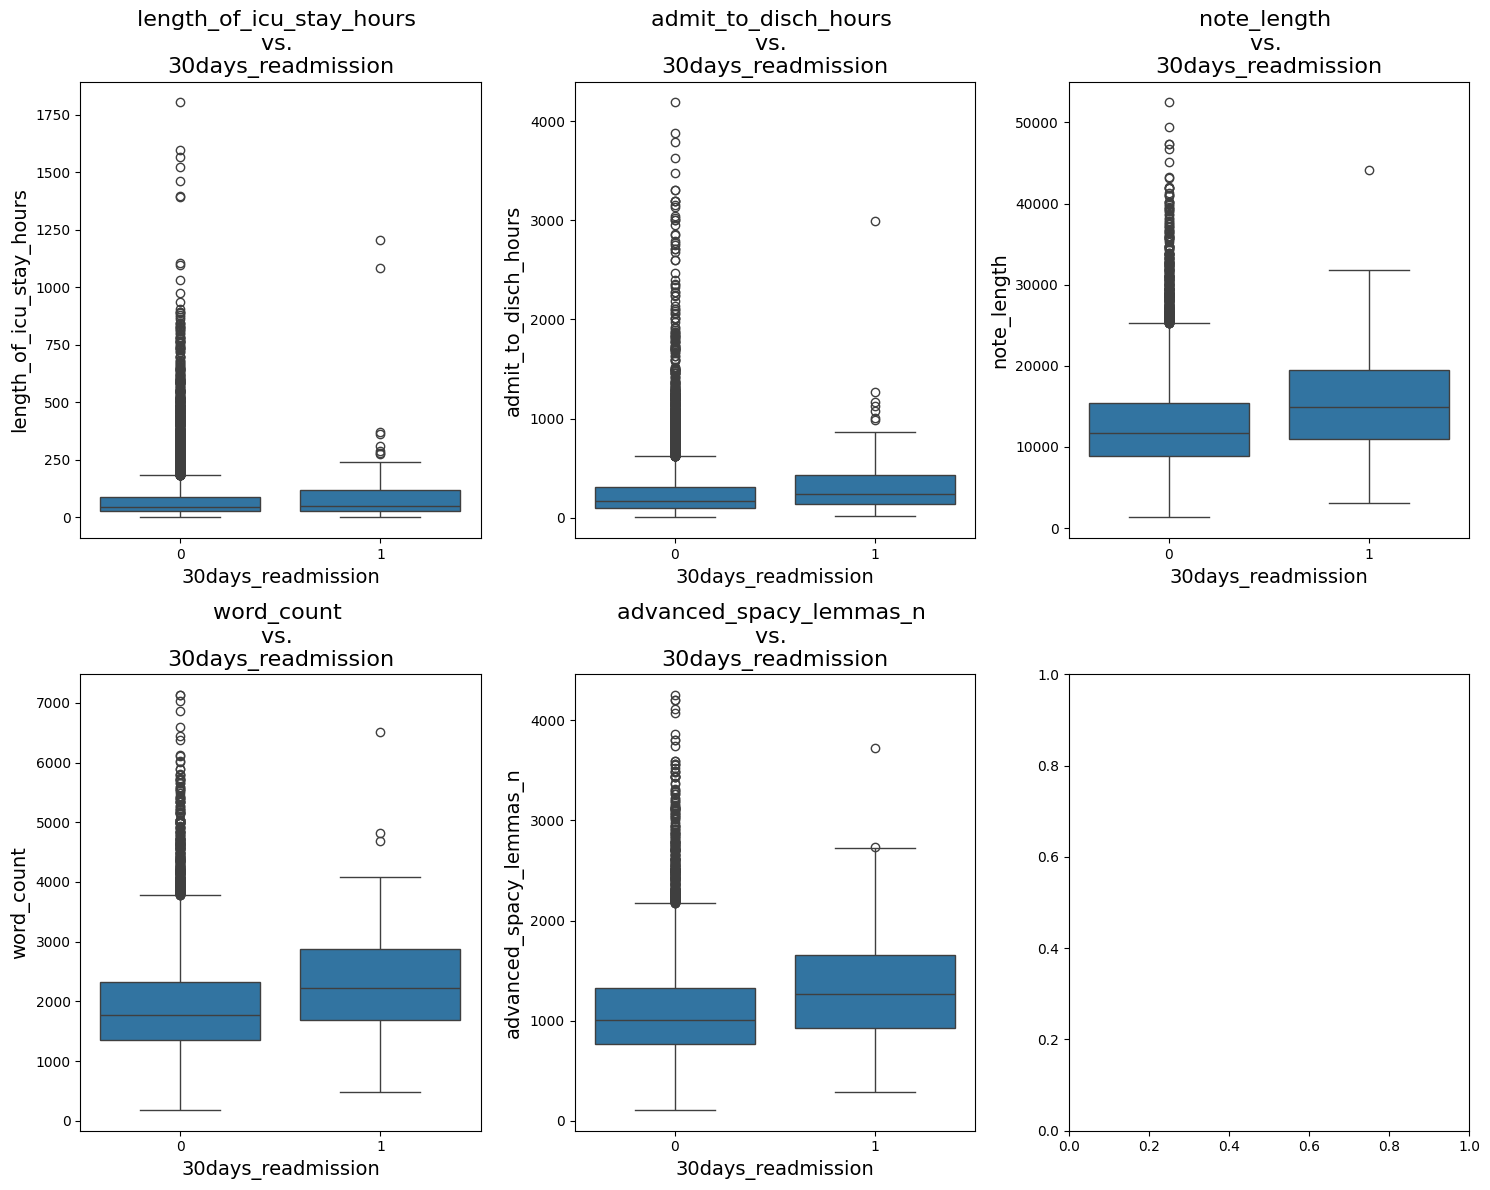

In [122]:
fig, axes = plt.subplots(2, 3, figsize=(15,12))
axes = axes.flatten()
i = 0
for col in cols_to_keep:
    sns.boxplot(x=tfidf_1to1_dropped_2['readmit_30days'], y=tfidf_1to1_dropped_2[col], ax=axes[i])
    axes[i].set_title(f"{col} \nvs. \n30days_readmission", fontsize=16)
    axes[i].set_ylabel(f'{col}', fontsize=14)
    axes[i].set_xlabel('30days_readmission', fontsize=14)
    i += 1

# Remove empty subplots (if any)
for i in range(i + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
# plt.savefig('__.jpg')
plt.show()

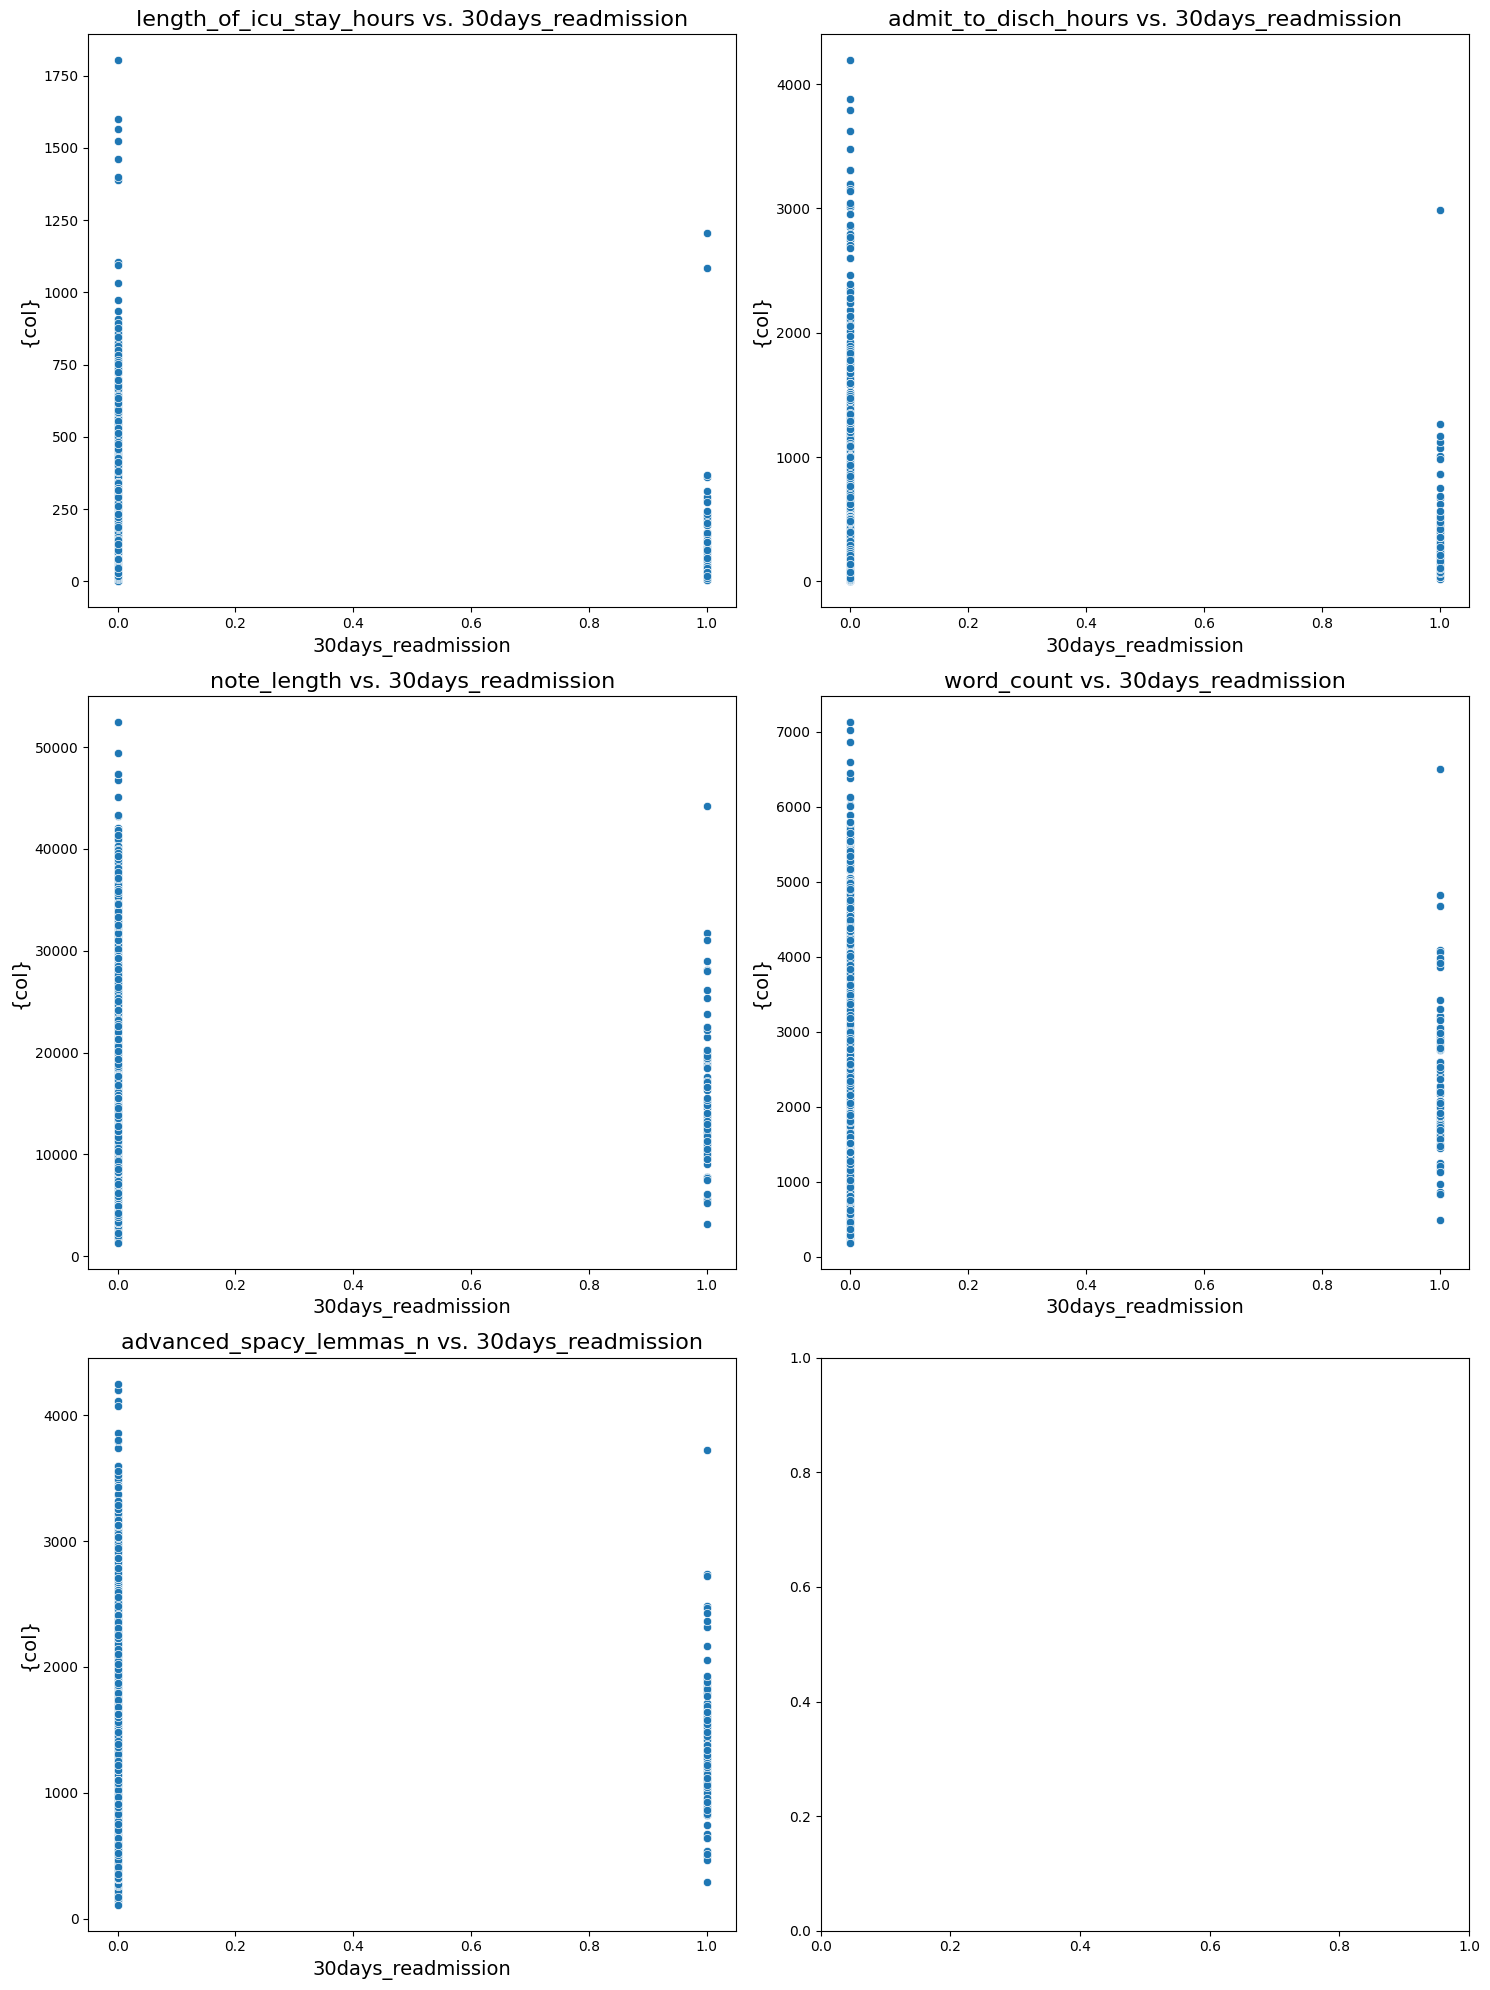

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 20))
axes = axes.flatten()
i = 0
for col in cols_to_keep:
    sns.scatterplot(x=tfidf_1to1_dropped_2['readmit_30days'], y=tfidf_1to1_dropped_2[col], ax=axes[i])
    axes[i].set_title(f"{col} vs. 30days_readmission", fontsize=16)
    axes[i].set_ylabel(f'{col}', fontsize=14)
    axes[i].set_xlabel('30days_readmission', fontsize=14)
    i += 1

# Remove empty subplots (if any)
for i in range(i + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
# plt.savefig('__.jpg')
plt.show()

In [ ]:
threshold = 0.8

# Identify binary features (those with only 2 unique values)
binary_features = [col for col in df_train.columns if df_train[col].nunique() == 2]

# Find feature pairs with high correlation (excluding self-correlation)
high_corr_pairs = []
for col in filtered_corr_matrix.columns:
    for row in filtered_corr_matrix.index:
        if col != row and abs(filtered_corr_matrix.loc[row, col]) > threshold:
            # Ensure at Least one variable is Not binary
            if not (col in binary_features and row in binary_features):
                high_corr_pairs.append((row, col))

# Remove duplicate pairs (since correlation matrix is symmetric)
unique_high_corr_pairs = list(set((tuple(sorted(pair))) for pair in high_corr_pairs))

# Create subplots
num_pairs = len(unique_high_corr_pairs)
cols = 3 # Number of columns in subplot grid
rows = int(np.ceil(num_pairs/cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows)) # Dynamic size adjustment
axes = axes.flatten() # Flatten axes array for easy indexing

# Plot scatter plots for each highly correlated pair
for idx, (feature1, feature2) in enumerate(unique_high_corr_pairs):
    sns.scatterplot(x=df_train[feature1], y=df_train[feature2], ax=axes[idx])
    axes[idx].set_title(f"{feature1} vs. {feature2}\nCorrelation: {corr_matrix.loc[feature1, feature2]:.2f}")

# Remove empty subplots (if any)
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
# plt.savefig('Scatterplots of highest correlated Features.jpg')
plt.show()

# 3. Feature Engineering

In [ ]:
from pathlib import Path

root_dir = Path.cwd().parent          # notebooks → mimic_readmit_clinbert
data_dir = root_dir / "data"
data_dir.mkdir(exist_ok=True)         # create folder if missing

tfidf_1to1_dropped_2 = pd.read_csv(data_dir / "tfidf_1to1_dropped_2.csv")
clinbert_1to1_dropped_2 = pd.read_csv(data_dir / "clinbert_1to1_dropped_2.csv")
tfidf_clinbert_1to1_dropped_2 = pd.read_csv(data_dir / "tfidf_clinbert_1to1_dropped_2.csv")

## 3.1 Examine the Distribution of Retained Variables

In [ ]:
# Plot distributions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(cols_to_keep):
    sns.histplot(tfidf_1to1_dropped_2[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(col)

# Remove empty subplots (if any)
for idx in range(i + 1, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

## 3.2 Assigned Scalers for Retained Variables

### Scaler Selection Logic

|Condition | Best Scaling Method |
|------------| -------------------- |
|Near-normal distributions with limited outliers| StandardScaler | 
|Non-Gaussian but no extreme outliers | MinMaxScaler | 
|Strong outliers, large spread, or moderate skew | RobustScaler | 
|Highly skewed (e.g., >1.0), heavy-tailed distribution | Log Transformation | 

In [ ]:
# %%writefile utils/auto_assign_scalers.py

# # Function to automatically classify variables into scalers based on statistical thresholds and predefined ordinal variables
# def auto_assign_scalers(df, feat2scale, ordinal_vars=None):
#     """
#     Automatically assigns numerical variables to appropriate scalers based on statistical thresholds.
    
#     Parameters:
#         feat2scale: A list of numerical variables needed to be scaled.
#         ordinal_vars (list): List of ordinal variables that should use MinMaxScaler.
        
#     Returns:
#         dict: Dictionary containing scaler assignments for each variable.
#     """
#     if ordinal_vars is None:
#         ordinal_vars = []  # Default empty list if no ordinal variables specified
    
#     scaler_groups = {"MinMaxScaler": [], "StandardScaler": [], "RobustScaler": [], "LogTransform": []}
#     statistics = {'Scaler': [], 'Variable': [], 'Why': [], 'Outlier_count': [], 'Skewness': [] , 'Kurtosis': [], 'Range_val/IQR':[]}

#     for col in feat2scale:
#         Q1 = df[col].quantile(0.25)
#         Q3 = df[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]

#         # Compute relevant statistics
#         range_val = df[col].max() - df[col].min()
#         median_distance = df[col].max() - df[col].median()
#         outlier_count = len(outliers)
#         skewness = df[col].skew()
#         kurtosis = df[col].kurt()

#         # Special handling for ordinal variables (force MinMaxScaler)
#         if col in ordinal_vars:
#             # For discrete ordinal variables, assign highly skewed ones for RobustScaler
#             if outlier_count > 10:  
#                 scaler_groups["RobustScaler"].append(col)
#                 statistics['Scaler'].append("RobustScaler")
#                 statistics['Variable'].append(col)
#                 statistics['Outlier_count'].append(outlier_count)
#                 statistics['Skewness'].append(abs(skewness))
#                 statistics['Kurtosis'].append(abs(kurtosis))
#                 statistics['Range_val/IQR'].append(range_val/IQR  if IQR != 0 else np.nan)
#                 statistics['Why'].append('ordinal variable with outlier > 10')
#             # For discrete ordinal variables, remaining for MinMaxScaler
#             else:
#                 scaler_groups["MinMaxScaler"].append(col)
#                 statistics['Scaler'].append("MinMaxScaler")
#                 statistics['Variable'].append(col)
#                 statistics['Outlier_count'].append(outlier_count)
#                 statistics['Skewness'].append(abs(skewness))
#                 statistics['Kurtosis'].append(abs(kurtosis))
#                 statistics['Range_val/IQR'].append(range_val/IQR  if IQR != 0 else np.nan)
#                 statistics['Why'].append('ordinal variables')
#         else:
#             # For remaining continuous variables, firstly, find out normal distribution and assign them under Standard scaler
#             # StandardScaler only for near-normal distributions with limited outliers
#             if outlier_count < 5 and abs(skewness) < 0.5 and abs(kurtosis) < 3.0 and range_val < 5 * IQR:
#                 scaler_groups["StandardScaler"].append(col)
#                 statistics['Scaler'].append("StandardScaler")
#                 statistics['Variable'].append(col)
#                 statistics['Outlier_count'].append(outlier_count)
#                 statistics['Skewness'].append(abs(skewness))
#                 statistics['Kurtosis'].append(abs(kurtosis))
#                 statistics['Range_val/IQR'].append(range_val/IQR  if IQR != 0 else np.nan)
#                 statistics['Why'].append('outlier < 5 & skew < 0.5 & kurtosis < 3 & range < 5 * IQR')
#             # For remaining continuous variables, secondly, find out less normal distribution and assign them under MinMaxScaler
#             # MinMaxScaler for non-Gaussian but no extreme outliers
#             elif outlier_count < 5 and abs(skewness) < 0.5 and range_val < 10 * IQR:
#                 scaler_groups["MinMaxScaler"].append(col)
#                 statistics['Scaler'].append("MinMaxScaler")
#                 statistics['Variable'].append(col)
#                 statistics['Outlier_count'].append(outlier_count)
#                 statistics['Skewness'].append(abs(skewness))
#                 statistics['Kurtosis'].append(abs(kurtosis))
#                 statistics['Range_val/IQR'].append(range_val/IQR  if IQR != 0 else np.nan)
#                 statistics['Why'].append('outlier < 5 & skew < 0.5 & range < 10 * IQR')
#             # For remaining continuous variables, thirdly, find out extreme skewed distribution and assign them under Log Transformation. As the degree of skewness increases, PowerTransformer generally performs better than RobustScaler.
#             # Log Transform for highly skewed distributions with heavy tails
#             elif abs(skewness) > 1.0 and kurtosis > 2.0:
#                 scaler_groups["LogTransform"].append(col)
#                 statistics['Scaler'].append("LogTransform")
#                 statistics['Variable'].append(col)
#                 statistics['Outlier_count'].append(outlier_count)
#                 statistics['Skewness'].append(abs(skewness))
#                 statistics['Kurtosis'].append(abs(kurtosis))
#                 statistics['Range_val/IQR'].append(range_val/IQR if IQR != 0 else np.nan)
#                 statistics['Why'].append('skew > 1.0 & kurtosis > 2.0') 
#             # For remaining continuous variables, fourthly, find out less extreme skewed distribution and assign them under RobustScaler
#             # RobustScaler for strong outliers, large spread, or moderate skew
#             elif outlier_count > 5 or range_val > 10 * IQR or abs(skewness) > 0.5:
#                 scaler_groups["RobustScaler"].append(col)
#                 statistics['Scaler'].append("RobustScaler")
#                 statistics['Variable'].append(col)
#                 statistics['Outlier_count'].append(outlier_count)
#                 statistics['Skewness'].append(abs(skewness))
#                 statistics['Kurtosis'].append(abs(kurtosis))
#                 statistics['Range_val/IQR'].append(range_val/IQR  if IQR != 0 else np.nan)
#                 statistics['Why'].append('outlier > 5 or skew > 0.5  or range > 10 * IQR')
#             # For remaining continuous variables, at last, assign the remaining variables for MinMaxScaler
#             else:
#                 scaler_groups["MinMaxScaler"].append(col)  # Default to StandardScaler
#                 statistics['Scaler'].append("MinMaxScaler")
#                 statistics['Variable'].append(col)
#                 statistics['Outlier_count'].append(outlier_count)
#                 statistics['Skewness'].append(abs(skewness))
#                 statistics['Kurtosis'].append(abs(kurtosis))
#                 statistics['Range_val/IQR'].append(range_val/IQR  if IQR != 0 else np.nan)
#                 statistics['Why'].append('Default as MinMaxScaler')  

#     return scaler_groups,  statistics

In [ ]:
# --- Make the project root importable ---------------------------------
import sys, pathlib

package_parent = pathlib.Path.cwd().parents[1]          # two levels up from notebooks/
if str(package_parent) not in sys.path:             # keep sys.path tidy
    sys.path.insert(0, str(package_parent))

In [ ]:
# Assume df already has a "lemmas" column
from mimic_readmit_clinbert.utils.auto_assign_scalers import auto_assign_scalers

# Apply the customized function auto_assign_scalers() to classify 6 numerical variables
scaler_results, statistics = auto_assign_scalers(tfidf_1to1_dropped_2, cols_to_keep)

# Display the assigned scalers for each variable
scaler_df = pd.DataFrame({key: pd.Series(val) for key, val in scaler_results.items()})
statistics_df = pd.DataFrame({key: pd.Series(val) for key, val in statistics.items()})
scaler_df = scaler_df.fillna('')

# Set up figure and axis
fig, ax = plt.subplots(figsize=(20, len(scaler_df) * 0.3))  # Adjust height based on number of rows

# Hide axes
ax.axis('off')

# Create the table and add it to the plot
table = pd.plotting.table(ax, scaler_df, loc='center', cellLoc='center', colWidths=[0.15]*len(scaler_df.columns))

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.2)

# Bold the header row
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold')



## 3.3 Split Data into Training and Testing Sets first, then Apply Feature Scaling

### 3.3.1 TF-IDF + Structure Data

In [ ]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_1to1_dropped_2.drop(columns=['readmit_30days']),
                                                    tfidf_1to1_dropped_2['readmit_30days'], test_size=0.3, 
                                                    random_state=42)

In [ ]:
# # --- Make the project root importable ---------------------------------
import sys, pathlib
import numpy as np

package_parent = pathlib.Path.cwd().parents[1]          # two levels up from notebooks/
if str(package_parent) not in sys.path:             # keep sys.path tidy
    sys.path.insert(0, str(package_parent))

from mimic_readmit_clinbert.utils.feature_scaling import feature_scaling
X_train_tfidf, X_test_tfidf = feature_scaling(X_train_tfidf, X_test_tfidf, cols_to_keep, statistics)

In [ ]:
X_train_tfidf[cols_to_keep].head()

In [ ]:
X_test_tfidf[cols_to_keep].head()

In [ ]:
# def feature_scaling(X_train, X_text, cols_to_scaling, statistics)

#     # Define the methods dictionary
#     method_dict = {
#         'reference_year': lambda df, col, ref_year: df[col] - ref_year,
#         'sin_cos_transform': lambda df, col: (
#             df.assign(**{f"{col}_sin": np.sin(2 * np.pi * df[col] / 12),
#                         f"{col}_cos": np.cos(2 * np.pi * df[col] / 12)}).drop(columns=[col])
#         ),
#         'MinMaxScaler': lambda: MinMaxScaler(), # Factory function to create a new instance
#         'StandardScaler': lambda: StandardScaler(),
#         'RobustScaler': lambda: RobustScaler(),
#         'LogTransform': lambda df, col: np.log1p(df[col])  # log(1 + X) to handle zero values
#     }

#     # Define a dictionary of each variable as key and its assigned scaler as value
#     variable_to_method = dict(zip(statistics['Variable'], statistics['Scaler']))

#     # Create a dictionary to store fitted scalers
#     scaler_instances = {}

#     year_cols = []  # Default empty list if no specified
        
#     month_cols = []  # Default empty list if no specified

#     # Apply scaler methods
#     for col in cols_to_scaling:
#         method = variable_to_method[col]
#         # Create a new scaler instance for each column
#         scaler = method_dict[method]() if method in ['MinMaxScaler', 'StandardScaler', 'RobustScaler'] else method_dict[method]

#         if col in year_cols:
#             # Subtract reference year
#             ref_year = X_train[col].min()
#             X_train[col] = scaler(X_train, col, ref_year)
#             X_test[col] = scaler(X_test, col, ref_year)
#             print(f'reference year for {col} is {ref_year}')
            
#         elif col in month_cols:
#             # Apply sin-cos transformation and update DataFrames
#             X_train = scaler(X_train, col)
#             X_test = scaler(X_test, col)
        
        
#         elif method == 'LogTransform':
#             # Apply log transformation
#             X_train[col] = scaler(X_train, col)
#             if col in X_test.columns:
#                 X_test[col] = scaler(X_test, col)

#         else:
#             # Fit on train, transform on both train and test
#             scaler_instances[col] = scaler.fit(X_train[[col]])
#             X_train[col] = scaler_instances[col].transform(X_train[[col]])
#             X_test[col] = scaler_instances[col].transform(X_test[[col]])
#     return X_train, X_test
    

### 3.3.2 ClinicalBERT + Structure Data

In [ ]:
X_train_cbert, X_test_cbert, y_train_cbert, y_test_cbert = train_test_split(clinbert_1to1_dropped_2.drop(columns=['readmit_30days']),
                                                    clinbert_1to1_dropped_2['readmit_30days'], test_size=0.3, 
                                                    random_state=42)

In [ ]:
# # --- Make the project root importable ---------------------------------
import sys, pathlib
import numpy as np

package_parent = pathlib.Path.cwd().parents[1]          # two levels up from notebooks/
if str(package_parent) not in sys.path:             # keep sys.path tidy
    sys.path.insert(0, str(package_parent))

from mimic_readmit_clinbert.utils.feature_scaling import feature_scaling
X_train_cbert, X_test_cbert = feature_scaling(X_train_cbert, X_test_cbert, cols_to_keep, statistics)

In [ ]:
X_test_cbert[cols_to_keep].head()

In [ ]:
X_train_cbert[cols_to_keep].head()

### 3.3.3 TF-IDF + ClinicalBERT + Structure Data

In [ ]:
X_train_tfbert, X_test_tfbert, y_train_tfbert, y_test_tfbert = train_test_split(tfidf_clinbert_1to1_dropped_2.drop(columns=['readmit_30days']),
                                                    tfidf_clinbert_1to1_dropped_2['readmit_30days'], test_size=0.3, 
                                                    random_state=42)

In [ ]:
# # --- Make the project root importable ---------------------------------
import sys, pathlib
import numpy as np

package_parent = pathlib.Path.cwd().parents[1]          # two levels up from notebooks/
if str(package_parent) not in sys.path:             # keep sys.path tidy
    sys.path.insert(0, str(package_parent))

from mimic_readmit_clinbert.utils.feature_scaling import feature_scaling
X_train_tfbert, X_test_tfbert = feature_scaling(X_train_tfbert, X_test_tfbert, cols_to_keep, statistics)

In [ ]:
X_test_tfbert[cols_to_keep].head()

In [ ]:
X_test_tfbert[cols_to_keep].head()

In [ ]:
from pathlib import Path

# ── 1. Locate / create the data folder ────────────────────────────────
root_dir = Path.cwd().parent            # notebooks → mimic_readmit_clinbert
data_dir = root_dir / "data"
data_dir.mkdir(exist_ok=True)           # won’t overwrite if it exists

# ── 2. Map *file-stem → object*  --------------------------------------
files = {
    "X_train_tfidf":      X_train_tfidf,
    "X_test_tfidf":       X_test_tfidf,
    "y_train_tfidf":      y_train_tfidf,
    "y_test_tfidf":       y_test_tfidf,

    "X_train_cbert":      X_train_cbert,
    "X_test_cbert":       X_test_cbert,
    "y_train_cbert":      y_train_cbert,
    "y_test_cbert":       y_test_cbert,

    "X_train_tfbert":     X_train_tfbert,
    "X_test_tfbert":      X_test_tfbert,
    "y_train_tfbert":     y_train_tfbert,
    "y_test_tfbert":      y_test_tfbert,
}

# ── 3. Write every DataFrame/Series once  -----------------------------
for stem, obj in files.items():
    # treat target vectors (Series) the same as DataFrames
    if stem.startswith("y_"):
        obj.to_csv(data_dir / f"{stem}.csv", index=False, header=True)
    else:
        obj.to_csv(data_dir / f"{stem}.csv", index=False)

In [ ]:
# # Get the current working directory
# current_dir = os.getcwd()

# # # Create the full path
# folder_path = os.path.join(current_dir, 'Saved')

# # Save to csv file
# X_train.to_csv(os.path.join(folder_path, "transformed_train_1.csv"), index=False)
# X_test.to_csv(os.path.join(folder_path, "transformed_test_1.csv"), index=False)
# y_train.to_csv(os.path.join(folder_path, "y_train_1.csv"), index=False)
# y_test.to_csv(os.path.join(folder_path, "y_test_1.csv"), index=False)

# print("Transformed datasets saved as CSV files.")

In [ ]:
# # Include versioning in the filename
# # Create version tag based on date or manual versioning
# version = "v1.0"
# timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")

# # Construct filename with version and timestamp
# filename = f"Saved/scaler_instances_{version}_{timestamp}.joblib"

# # Save metadata along with the object
# metadata = {
#     "scaler": scaler_instances,
#     "created_by": "Sheng Miao",
#     "date_saved": timestamp,
#     "version": version,
#     "description": "StandardScaler fitted on structured and TF-IDF combined dataset for 30-day readmission model"
# }

# joblib.dump(metadata, filename)

# 4. Modeling

load saved csv files

In [ ]:
# Load in bulk

import pandas as pd
from pathlib import Path

# ── 1. Point to the folder that holds the 12 files ─────────────────────
root_dir = Path.cwd().parent          # notebooks → mimic_readmit_clinbert
data_dir = root_dir / "data"

# ── 2. List the file stems I saved earlier ───────────────────────────
stems = [
    "X_train_tfidf",  "X_test_tfidf",  "y_train_tfidf",  "y_test_tfidf",
    "X_train_cbert",  "X_test_cbert",  "y_train_cbert",  "y_test_cbert",
    "X_train_tfbert", "X_test_tfbert", "y_train_tfbert", "y_test_tfbert",
]

# ── 3. Bulk-load everything into a dict ────────────────────────────────
loaded = {
    stem: pd.read_csv(data_dir / f"{stem}.csv")
    for stem in stems
}

# ── 4. Convert the y_… DataFrames (single column) to 1-D Series ────────
for stem in stems:
    if stem.startswith("y_"):
        loaded[stem] = loaded[stem].squeeze("columns")

# ── 5. Optionally put them back into the notebook’s global namespace ──
globals().update(loaded)

# I can now use variables directly:
print(X_train_tfidf.shape, y_test_cbert.head())


(6544, 2005) 0    0
1    0
2    0
3    0
4    0
Name: readmit_30days, dtype: int64


## 4.1 Logistic Regression + Optuna (with regulation)

### 4.1.1 TF-IDF + Structure Data

Reasons: 
- Handles high-dimensional sparse data (like TF-IDF) very well.
- Fast to train and easy to interpret (especially with L1 or L2 regularization).
- A solid baseline model.

In [67]:
# # Reduce verbosity and show progress bars
# optuna.logging.set_verbosity(optuna.logging.WARNING)


# # Create a stratified tuning subset: preserve all class 1, sample class 0
# positive_idx = y_train[y_train == 1].index
# negative_idx = y_train[y_train == 0].sample(n=1000, random_state=42).index  # Sample 1000 from class 0
# subset_idx = positive_idx.union(negative_idx)

# X_tune = X_train.loc[subset_idx]
# y_tune = y_train.loc[subset_idx]


# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# results = {}

# # Optimization for L1, L2, and ElasticNet
# def objective(trial, penalty_type):
#     C = trial.suggest_float('C', 1e-4, 1e2, log=True)
#     solver = 'saga'
#     params = {
#         'penalty': penalty_type,
#         'C': C,
#         'solver': solver,
#         'max_iter': 2000,
#         'random_state': 42
#     }
#     if penalty_type == 'elasticnet':
#         l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
#         params['l1_ratio'] = l1_ratio

#     model = LogisticRegression(**params)
#     scores = cross_val_score(model, X_tune, y_tune, cv=cv, scoring='roc_auc', n_jobs=-1)
#     return scores.mean()

# # Run Optuna optimization for each penalty type
# for penalty in ['l1', 'l2', 'elasticnet']:
#     print(f"\nOptimizing penalty: {penalty}")
#     study = optuna.create_study(direction='maximize')
#     study.optimize(lambda trial: objective(trial, penalty), n_trials=15, show_progress_bar=True)
#     results[penalty] = study.best_value

# # Plotting the results
# penalties = list(results.keys())
# auc_scores = list(results.values())

# # Plot
# plt.figure(figsize=(8, 4))
# bars = plt.barh(penalties, auc_scores, height=0.5, color=plt.cm.viridis(0.6))

# # Add AUC score labels to each bar
# for bar, score in zip(bars, auc_scores):
#     plt.text(score + 0.01, bar.get_y() + bar.get_height() / 2,
#              f"{score:.3f}", va='center', fontsize=10)

# # Styling
# plt.xlim(0.5, 1.0)
# plt.xlabel('ROC AUC', fontsize=12)
# plt.title('Best ROC AUC Scores by Penalty Type (Optuna)', fontsize=13)
# plt.grid(axis='x', linestyle='--', alpha=0.6)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)
# plt.tight_layout()
# plt.show()

# # Runing took 38m 44.8s

Improvements:
- Expand and Refine Hyperparameter Search Space: 
  -  C = trial.suggest_float('C', 1e-5, 1e2, log=True), 
  -  'max_iter': 3000,
  -  'class_weight': 'balanced',
  -  l1_ratio = trial.suggest_float('l1_ratio', 0.05, 0.95)
  -  n_trials=25
- Stratified Cross-Validation + SMOTE

SMOTE creates synthetic samples for the minority class to increase minority class representativeness. It must be applied within each fold, or else I'll leak information.

In [68]:
# # Reduce verbosity and show progress bars
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# # Save original stdout to restore later (Save all the printed output (including progress bars and best parameters))
# original_stdout = sys.stdout
# # Redirect stdout to a file
# log_path = "Saved/logistical_regression_progress_bar_logs.txt"
# sys.stdout = open(log_path, "w")

# # Create a stratified tuning subset: preserve all class 1, sample class 0
# positive_idx = y_train[y_train == 1].index
# negative_idx = y_train[y_train == 0].sample(n=1000, random_state=42).index  # Sample 1000 from class 0
# subset_idx = positive_idx.union(negative_idx)

# X_tune = X_train.loc[subset_idx]
# y_tune = y_train.loc[subset_idx]


# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Maintains class distribution in CV folds
# results = {}

# # Optimization for L1, L2, and ElasticNet
# def objective(trial, penalty_type):
#     C = trial.suggest_float('C', 1e-5, 1e2, log=True)
#     params = {
#         'penalty': penalty_type,
#         'C': C,
#         'solver': 'saga',
#         'max_iter': 3000,
#         'random_state': 42,
#         'class_weight': 'balanced'  # NEW: Adjusts for imbalance
#     }
#     if penalty_type == 'elasticnet':
#         l1_ratio = trial.suggest_float('l1_ratio', 0.05, 0.95)
#         params['l1_ratio'] = l1_ratio

#     model = LogisticRegression(**params)
#     smote = SMOTE(random_state=42) # Data Balancing or class weight tuning

#     pipe = ImbPipeline([
#         ('smote', smote),
#         ('clf', model)
#     ])

#     scores = cross_val_score(pipe, X_tune, y_tune, cv=cv, scoring='roc_auc', n_jobs=-1)
#     return scores.mean()

# # Run Optuna optimization for each penalty type
# for penalty in ['l1', 'l2', 'elasticnet']:
#     print(f"\nOptimizing penalty: {penalty}")
#     study = optuna.create_study(direction='maximize')
#     study.optimize(lambda trial: objective(trial, penalty), n_trials=25, show_progress_bar=True)
#     results[penalty] = study.best_value
#     print(f"Best AUC for {penalty}: {study.best_value:.4f}")
#     print(f"Best Params: {study.best_params}")


# # Plotting the results
# penalties = list(results.keys())
# auc_scores = list(results.values())

# # Plot
# plt.figure(figsize=(8, 4))
# bars = plt.barh(penalties, auc_scores, height=0.5, color=plt.cm.viridis(0.6))

# # Add AUC score labels to each bar
# for bar, score in zip(bars, auc_scores):
#     plt.text(score + 0.01, bar.get_y() + bar.get_height() / 2,
#              f"{score:.3f}", va='center', fontsize=10)

# # Styling
# plt.xlim(0.5, 1.0)
# plt.xlabel('ROC AUC', fontsize=12)
# plt.title('Best ROC AUC Scores by Penalty Type (Optuna)', fontsize=13)
# plt.grid(axis='x', linestyle='--', alpha=0.6)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)
# plt.tight_layout()
# plt.savefig("Saved/logistical_regression_roc_auc_comparison.png", dpi=300, bbox_inches='tight')
# plt.show()

# sys.stdout.close() # Closes the log file (log_path) so the buffered content is properly written to disk. 
# sys.stdout = original_stdout # Restores standard output back to my Jupyter notebook.

# # Running took 142m 21.2s

,Avg_Precision,Precision,Recall,Best_Params
Penalty,,,,
l1,0.155499,0.108225,0.396825,"{'penalty': 'l1', 'solver': 'saga', 'max_iter'..."
l2,0.144042,0.086053,0.460317,"{'penalty': 'l2', 'solver': 'saga', 'max_iter'..."
elasticnet,0.138290,0.089506,0.460317,"{'penalty': 'elasticnet', 'solver': 'saga', 'm..."


🔍  Quick demo loop just to show a progress bar ↓


Best trial: 5. Best value: 0.136576: 100%|██████████| 10/10 [1:11:11<00:00, 427.18s/it]


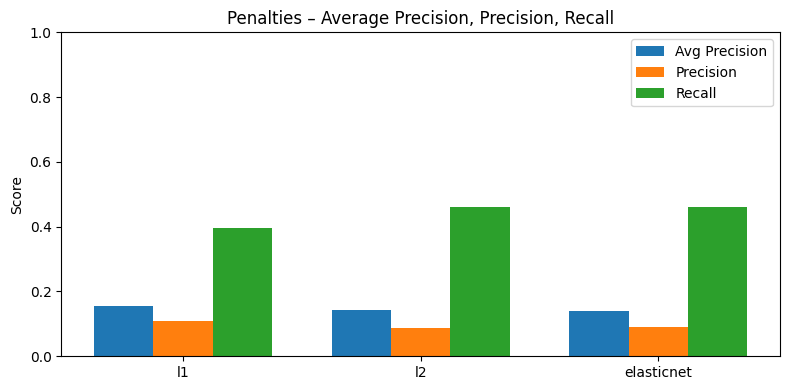

In [8]:
import sys, optuna, warnings
from pathlib import Path
from joblib import parallel_backend
from contextlib import redirect_stdout

warnings.filterwarnings("ignore")     # SMOTE minors
optuna.logging.set_verbosity(optuna.logging.WARNING)
# ─────────────────────────── paths / logging ──────────────────────────
root_dir  = Path.cwd().parent
saved_dir = root_dir / "saved"
saved_dir.mkdir(exist_ok=True)

log_file  = saved_dir / f"logreg_optuna_tfidf_{pd.Timestamp.now():%Y%m%d}.txt"


# ---------- build tuning subset ----------
pos_idx = y_train_tfidf[y_train_tfidf == 1].index
neg_idx = y_train_tfidf[y_train_tfidf == 0].sample(n=1_000, random_state=42).index
subset  = pos_idx.union(neg_idx)
X_tune, y_tune = X_train_tfidf.loc[subset], y_train_tfidf.loc[subset]

cv  = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results      = {}   # stores best Average-Precision per penalty
metric_table = []   # rows: penalty, AP, precision, recall

# ───────────────────────── optimisation & logging ─────────────────────
# --- redirect only *inside* the context so stdout is always restored ---
with open(log_file, "w") as lf, redirect_stdout(lf):

    def objective(trial, penalty):
        """Optuna objective: maximise Average-Precision."""
        C = trial.suggest_float("C", 1e-5, 1e2, log=True)
        params = dict(penalty=penalty, C=C, solver="saga",
                    max_iter=3_000, random_state=42,
                    class_weight="balanced")
        if penalty == "elasticnet":
            params["l1_ratio"] = trial.suggest_float("l1_ratio", 0.05, 0.95)

        pipe = ImbPipeline([
            ("smote", SMOTE(random_state=42)),
            ("clf",  LogisticRegression(**params))
        ])

        # --- serial CV inside a single joblib backend ---
        with parallel_backend("loky", inner_max_num_threads=1):
            score = cross_val_score(pipe, X_tune, y_tune,
                                    cv=cv, scoring="average_precision",
                                    n_jobs=1)              #  ← no worker storm
        return score.mean()

    print(" Quick demo loop just to show a progress bar ↓")

    for pen in ["l1", "l2", "elasticnet"]:
        print(f"\nOptimising {pen} …")
        study = optuna.create_study(direction="maximize")
        # progress bar off because we’re logging to file
        study.optimize(lambda tr: objective(tr, pen),
                    n_trials=25, show_progress_bar=False)
        best_AP = study.best_value
        best_params = study.best_params

        print(f" best score  {best_AP:.4f}")
        print(f" best params {best_params}")

 # ── evaluate precision & recall at threshold 0.5 ──────────────
        best_params_full = dict(
            penalty=pen,
            solver="saga",
            max_iter=3_000,
            random_state=42,
            class_weight="balanced",
            **{k: v for k, v in best_params.items() if k in ("C", "l1_ratio")},
        )
        pipe = ImbPipeline([
            ("smote", SMOTE(random_state=42)),
            ("clf",   LogisticRegression(**best_params_full)),
        ])

        probas = cross_val_predict(   # returns predicted probabilities
            pipe, X_tune, y_tune,
            cv=cv,
            method="predict_proba",
            n_jobs=1,
        )[:, 1]                       # positive-class column

        y_pred = (probas >= 0.50).astype(int)
        prec   = precision_score(y_tune, y_pred)
        rec    = recall_score(y_tune, y_pred)

        results[pen] = best_AP
        metric_table.append(
            dict(Penalty=pen, Avg_Precision=best_AP,
                 Precision=prec, Recall=rec,
                 Best_Params=best_params_full)
        )

# ───────────────── summary DataFrame ──────────────────────────────────
summary_df = pd.DataFrame(metric_table).set_index("Penalty")
display(summary_df)   # Jupyter pretty table


# stdout automatically restored here
# ----- main optimisation was logged to file above --------------------
# stdout is now back to the notebook
print("🔍  Quick demo loop just to show a progress bar ↓")

for pen in ["l1", "l2", "elasticnet"]:
    # 1-trial dummy study – finishes in a second but displays the bar
    demo = optuna.create_study(direction="maximize")
    demo.optimize(lambda tr: objective(tr, pen),
                  n_trials=10, show_progress_bar=True)
# ───────────────── grouped bar chart ──────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 4))
x        = range(len(summary_df))
width    = 0.25

ax.bar([i - width     for i in x], summary_df["Avg_Precision"], width,
       label="Avg Precision")
ax.bar([i             for i in x], summary_df["Precision"],     width,
       label="Precision")
ax.bar([i + width     for i in x], summary_df["Recall"],        width,
       label="Recall")

ax.set_xticks(x)
ax.set_xticklabels(summary_df.index)
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
ax.set_title("Penalties – Average Precision, Precision, Recall")
ax.legend()
plt.tight_layout()
plt.show()


### 4.1.2 ClinicBERT + Structure Data

,Avg_Precision,Precision,Recall,Best_Params
Penalty,,,,
l1,0.136152,0.077647,0.523810,"{'penalty': 'l1', 'solver': 'saga', 'max_iter'..."
l2,0.126731,0.082160,0.555556,"{'penalty': 'l2', 'solver': 'saga', 'max_iter'..."
elasticnet,0.134582,0.078571,0.523810,"{'penalty': 'elasticnet', 'solver': 'saga', 'm..."


🔍  Quick demo loop just to show a progress bar ↓


Best trial: 7. Best value: 0.134416: 100%|██████████| 10/10 [16:18<00:00, 97.83s/it] 


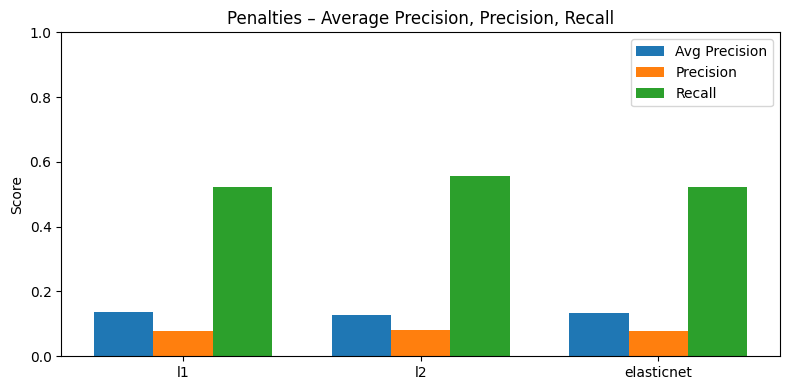

In [7]:
import sys, optuna, warnings
from pathlib import Path
from joblib import parallel_backend
from contextlib import redirect_stdout

warnings.filterwarnings("ignore")     # SMOTE minors
optuna.logging.set_verbosity(optuna.logging.WARNING)
# ─────────────────────────── paths / logging ──────────────────────────
root_dir  = Path.cwd().parent
saved_dir = root_dir / "saved"
saved_dir.mkdir(exist_ok=True)

log_file  = saved_dir / f"logreg_optuna_cbert_{pd.Timestamp.now():%Y%m%d}.txt"


# ---------- build tuning subset ----------
pos_idx = y_train_cbert[y_train_cbert == 1].index
neg_idx = y_train_cbert[y_train_cbert == 0].sample(n=1_000, random_state=42).index
subset  = pos_idx.union(neg_idx)
X_tune, y_tune = X_train_cbert.loc[subset], y_train_cbert.loc[subset]

cv  = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results      = {}   # stores best Average-Precision per penalty
metric_table = []   # rows: penalty, AP, precision, recall

# ───────────────────────── optimisation & logging ─────────────────────
# --- redirect only *inside* the context so stdout is always restored ---
with open(log_file, "w") as lf, redirect_stdout(lf):

    def objective(trial, penalty):
        """Optuna objective: maximise Average-Precision."""
        C = trial.suggest_float("C", 1e-5, 1e2, log=True)
        params = dict(penalty=penalty, C=C, solver="saga",
                    max_iter=3_000, random_state=42,
                    class_weight="balanced")
        if penalty == "elasticnet":
            params["l1_ratio"] = trial.suggest_float("l1_ratio", 0.05, 0.95)

        pipe = ImbPipeline([
            ("smote", SMOTE(random_state=42)),
            ("clf",  LogisticRegression(**params))
        ])

        # --- serial CV inside a single joblib backend ---
        with parallel_backend("loky", inner_max_num_threads=1):
            score = cross_val_score(pipe, X_tune, y_tune,
                                    cv=cv, scoring="average_precision",
                                    n_jobs=1)              #  ← no worker storm
        return score.mean()

    print(" Quick demo loop just to show a progress bar ↓")

    for pen in ["l1", "l2", "elasticnet"]:
        print(f"\nOptimising {pen} …")
        study = optuna.create_study(direction="maximize")
        # progress bar off because we’re logging to file
        study.optimize(lambda tr: objective(tr, pen),
                    n_trials=25, show_progress_bar=False)
        best_AP = study.best_value
        best_params = study.best_params

        print(f" best score  {best_AP:.4f}")
        print(f" best params {best_params}")

 # ── evaluate precision & recall at threshold 0.5 ──────────────
        best_params_full = dict(
            penalty=pen,
            solver="saga",
            max_iter=3_000,
            random_state=42,
            class_weight="balanced",
            **{k: v for k, v in best_params.items() if k in ("C", "l1_ratio")},
        )
        pipe = ImbPipeline([
            ("smote", SMOTE(random_state=42)),
            ("clf",   LogisticRegression(**best_params_full)),
        ])

        probas = cross_val_predict(   # returns predicted probabilities
            pipe, X_tune, y_tune,
            cv=cv,
            method="predict_proba",
            n_jobs=1,
        )[:, 1]                       # positive-class column

        y_pred = (probas >= 0.50).astype(int)
        prec   = precision_score(y_tune, y_pred)
        rec    = recall_score(y_tune, y_pred)

        results[pen] = best_AP
        metric_table.append(
            dict(Penalty=pen, Avg_Precision=best_AP,
                 Precision=prec, Recall=rec,
                 Best_Params=best_params_full)
        )

# ───────────────── summary DataFrame ──────────────────────────────────
summary_df = pd.DataFrame(metric_table).set_index("Penalty")
display(summary_df)   # Jupyter pretty table


# stdout automatically restored here
# ----- main optimisation was logged to file above --------------------
# stdout is now back to the notebook
print("🔍  Quick demo loop just to show a progress bar ↓")

for pen in ["l1", "l2", "elasticnet"]:
    # 1-trial dummy study – finishes in a second but displays the bar
    demo = optuna.create_study(direction="maximize")
    demo.optimize(lambda tr: objective(tr, pen),
                  n_trials=10, show_progress_bar=True)
# ───────────────── grouped bar chart ──────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 4))
x        = range(len(summary_df))
width    = 0.25

ax.bar([i - width     for i in x], summary_df["Avg_Precision"], width,
       label="Avg Precision")
ax.bar([i             for i in x], summary_df["Precision"],     width,
       label="Precision")
ax.bar([i + width     for i in x], summary_df["Recall"],        width,
       label="Recall")

ax.set_xticks(x)
ax.set_xticklabels(summary_df.index)
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
ax.set_title("Penalties – Average Precision, Precision, Recall")
ax.legend()
plt.tight_layout()
plt.show()


### 4.1.3 TF-DF + ClinicBERT + Structure Data

,Avg_Precision,Precision,Recall,Best_Params
Penalty,,,,
l1,0.160765,0.108949,0.444444,"{'penalty': 'l1', 'solver': 'saga', 'max_iter'..."
l2,0.128470,0.079284,0.492063,"{'penalty': 'l2', 'solver': 'saga', 'max_iter'..."
elasticnet,0.140398,0.080097,0.523810,"{'penalty': 'elasticnet', 'solver': 'saga', 'm..."


🔍  Quick demo loop just to show a progress bar ↓


Best trial: 4. Best value: 0.136336: 100%|██████████| 10/10 [1:05:38<00:00, 393.89s/it]


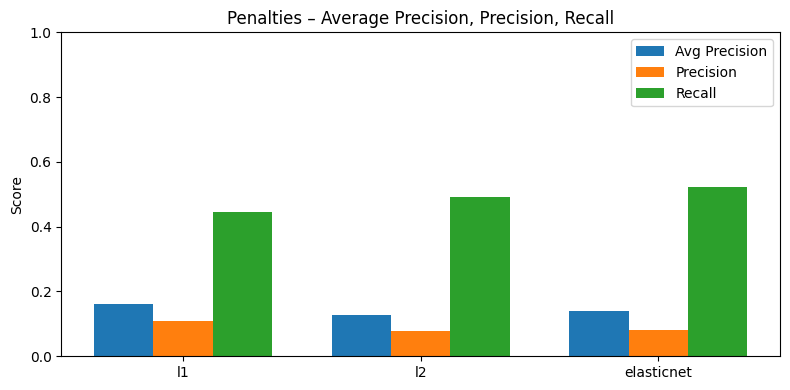

In [ ]:
import sys, optuna, warnings
from pathlib import Path
from joblib import parallel_backend
from contextlib import redirect_stdout

warnings.filterwarnings("ignore")     # SMOTE minors
optuna.logging.set_verbosity(optuna.logging.WARNING)
# ─────────────────────────── paths / logging ──────────────────────────
root_dir  = Path.cwd().parent
saved_dir = root_dir / "saved"
saved_dir.mkdir(exist_ok=True)

log_file  = saved_dir / f"logreg_optuna_tfbert_{pd.Timestamp.now():%Y%m%d}.txt"


# ---------- build tuning subset ----------
pos_idx = y_train_tfbert[y_train_tfbert == 1].index
neg_idx = y_train_tfbert[y_train_tfbert == 0].sample(n=1_000, random_state=42).index
subset  = pos_idx.union(neg_idx)
X_tune, y_tune = X_train_tfbert.loc[subset], y_train_tfbert.loc[subset]

cv  = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results      = {}   # stores best Average-Precision per penalty
metric_table = []   # rows: penalty, AP, precision, recall

# ───────────────────────── optimisation & logging ─────────────────────
# --- redirect only *inside* the context so stdout is always restored ---
with open(log_file, "w") as lf, redirect_stdout(lf):

    def objective(trial, penalty):
        """Optuna objective: maximise Average-Precision."""
        C = trial.suggest_float("C", 1e-5, 1e2, log=True)
        params = dict(penalty=penalty, C=C, solver="saga",
                    max_iter=3_000, random_state=42,
                    class_weight="balanced")
        if penalty == "elasticnet":
            params["l1_ratio"] = trial.suggest_float("l1_ratio", 0.05, 0.95)

        pipe = ImbPipeline([
            ("smote", SMOTE(random_state=42)),
            ("clf",  LogisticRegression(**params))
        ])

        # --- serial CV inside a single joblib backend ---
        with parallel_backend("loky", inner_max_num_threads=1):
            score = cross_val_score(pipe, X_tune, y_tune,
                                    cv=cv, scoring="average_precision",
                                    n_jobs=2)              #  ← no worker storm
        return score.mean()

    print(" Quick demo loop just to show a progress bar ↓")

    for pen in ["l1", "l2", "elasticnet"]:
        print(f"\nOptimising {pen} …")
        study = optuna.create_study(direction="maximize")
        # progress bar off because we’re logging to file
        study.optimize(lambda tr: objective(tr, pen),
                    n_trials=25, show_progress_bar=False)
        best_AP = study.best_value
        best_params = study.best_params

        print(f" best score  {best_AP:.4f}")
        print(f" best params {best_params}")

 # ── evaluate precision & recall at threshold 0.5 ──────────────
        best_params_full = dict(
            penalty=pen,
            solver="saga",
            max_iter=3_000,
            random_state=42,
            class_weight="balanced",
            **{k: v for k, v in best_params.items() if k in ("C", "l1_ratio")},
        )
        pipe = ImbPipeline([
            ("smote", SMOTE(random_state=42)),
            ("clf",   LogisticRegression(**best_params_full)),
        ])

        probas = cross_val_predict(   # returns predicted probabilities
            pipe, X_tune, y_tune,
            cv=cv,
            method="predict_proba",
            n_jobs=1,
        )[:, 1]                       # positive-class column

        y_pred = (probas >= 0.50).astype(int)
        prec   = precision_score(y_tune, y_pred)
        rec    = recall_score(y_tune, y_pred)

        results[pen] = best_AP
        metric_table.append(
            dict(Penalty=pen, Avg_Precision=best_AP,
                 Precision=prec, Recall=rec,
                 Best_Params=best_params_full)
        )

# ───────────────── summary DataFrame ──────────────────────────────────
summary_df = pd.DataFrame(metric_table).set_index("Penalty")
display(summary_df)   # Jupyter pretty table


# stdout automatically restored here
# ----- main optimisation was logged to file above --------------------
# stdout is now back to the notebook
print("🔍  Quick demo loop just to show a progress bar ↓")

for pen in ["l1", "l2", "elasticnet"]:
    # 1-trial dummy study – finishes in a second but displays the bar
    demo = optuna.create_study(direction="maximize")
    demo.optimize(lambda tr: objective(tr, pen),
                  n_trials=10, show_progress_bar=True)
    
# ───────────────── grouped bar chart ──────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 4))
x        = range(len(summary_df))
width    = 0.25

ax.bar([i - width     for i in x], summary_df["Avg_Precision"], width,
       label="Avg Precision")
ax.bar([i             for i in x], summary_df["Precision"],     width,
       label="Precision")
ax.bar([i + width     for i in x], summary_df["Recall"],        width,
       label="Recall")

ax.set_xticks(x)
ax.set_xticklabels(summary_df.index)
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
ax.set_title("Penalties – Average Precision, Precision, Recall")
ax.legend()
plt.tight_layout()
plt.show()


## 4.2 Random Forest + Optuna

In [ ]:
# # Define Optuna Objective Function
# # Optuna objective
# def rf_objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 200, 500),
#         'max_depth': trial.suggest_int('max_depth', 3, 30), 
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 20), 
#         'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),  
#         'bootstrap': trial.suggest_categorical('bootstrap', [True]),
#         'random_state': 42,
#         'n_jobs': -1
#     }
#     model = RandomForestClassifier(**params)
#     auc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
#     return auc_scores.mean()

In [ ]:
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# n_outer_trial = 15
# n_inner_trial = 3

# # Run the study
# rf_study = optuna.create_study(direction='maximize', study_name='RandomForest Optimization')


# # Run optimization with manual loop + tqdm
# for _ in tqdm(range(n_outer_trial), desc='Optimizing'):
#     rf_study.optimize(rf_objective, n_trials=n_inner_trial)


# # Extract best score and parameters
# best_score = rf_study.best_value
# best_params = rf_study.best_params

# # Results
# print(f"\nBest AUC: {best_score:.4f}")
# print("Best Parameters:", best_params)

# # === Save everything ===
# os.makedirs("Saved", exist_ok=True)

# # 1. Save Optuna study
# joblib.dump(rf_study, "Saved/random_forest_optuna_study.pkl") # Full Optuna study object (all trials)

# # 2. Save best parameters to JSON
# with open("Saved/random_forest_optuna_best_params.json", "w") as f:   # Best hyperparameters
#     json.dump(best_params, f, indent=2)

# # 3. Save trial scores to CSV
# trial_scores = pd.DataFrame({
#     "trial": [t.number for t in rf_study.trials],
#     "auc_score": [t.value for t in rf_study.trials]
# })
# trial_scores.to_csv("Saved/random_forest_optuna_trial_scores.csv", index=False)  # Trial number and AUC for each trial


In [ ]:
# # 4. Plotting and save figure
# plt.figure(figsize=(10, 6))
# plt.plot(trial_scores["trial"], trial_scores["auc_score"], marker='o', linewidth=2, label='AUC per Trial')
# plt.axhline(best_score, color='r', linestyle='--', label='Best AUC')
# plt.title('Random Forest ROC AUC per Trial (Optuna)', fontsize=14)
# plt.xlabel('Trial', fontsize=12)
# plt.ylabel('ROC AUC', fontsize=12)
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.legend()
# plt.tight_layout()
# plt.savefig("Saved/random_forest_optuna.png", dpi=300, bbox_inches='tight')
# plt.show()


## 4.3 Gradient Boosting XGBoost + Optuna 

### 4.3.1 TF-IDF + Structure Data

Best trial: 4. Best value: 0.0235914: 100%|██████████| 100/100 [33:01<00:00, 19.81s/it]


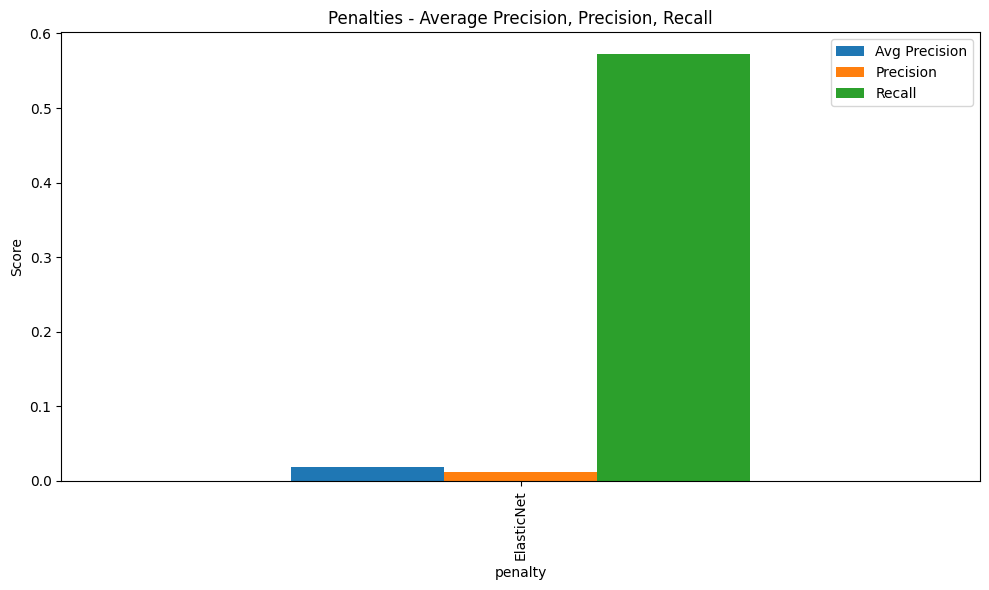

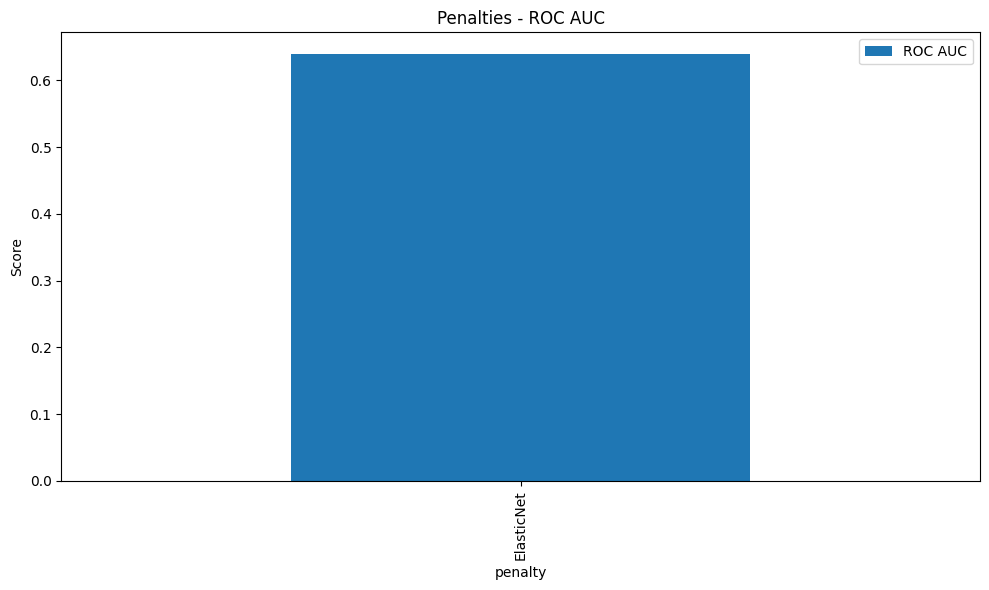

In [ ]:
%matplotlib inline

# run this *before* import
import sys, pathlib
project_root = pathlib.Path.cwd().parent          # notebooks → project root
sys.path.append(str(project_root))

import importlib, utils.XGBoost_optuna_AP_tuner as t; importlib.reload(t)
from utils.XGBoost_optuna_AP_tuner import run_xgb_optuna

cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

study_tfidf, results_tfidf = run_xgb_optuna(X_train_tfidf, y_train_tfidf, dataset_name="tfidf", sampler="ros", cv=cv3)

### 4.3.2 ClinicBERT + Structure Data

Best trial: 41. Best value: 0.0447241: 100%|██████████| 100/100 [15:38<00:00,  9.38s/it]


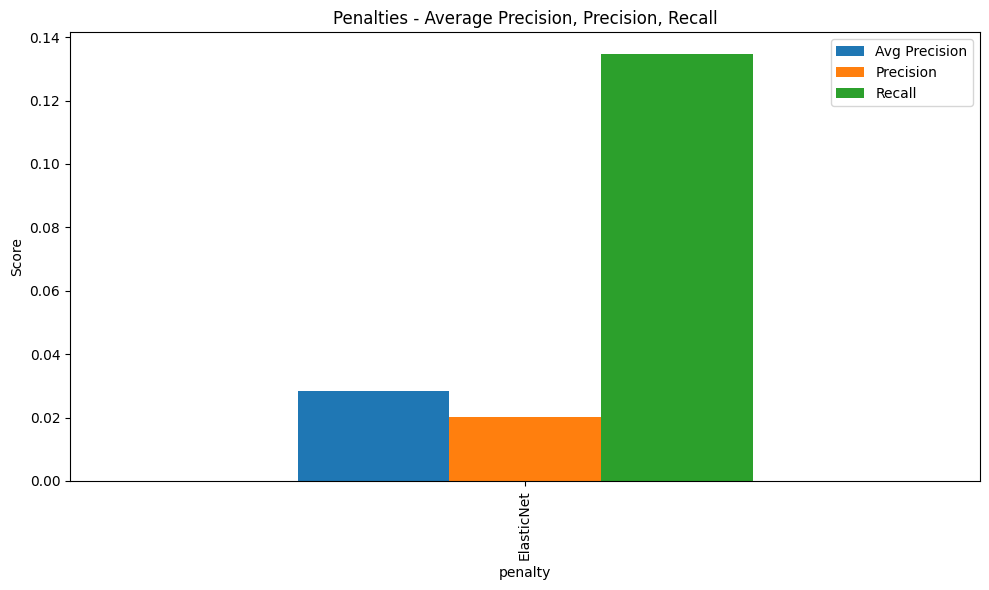

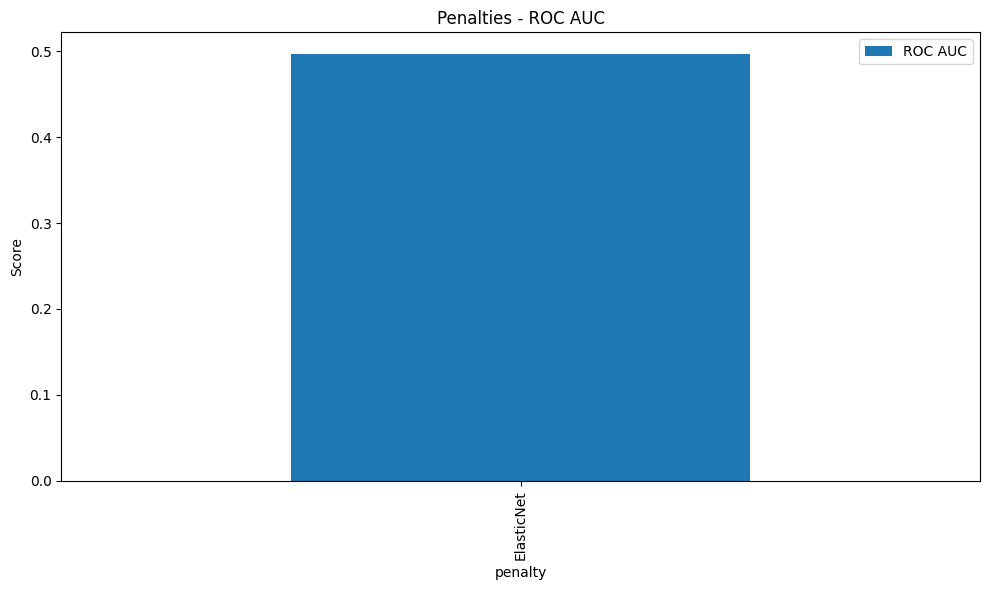

In [80]:
study_cbert, results_cbert = run_xgb_optuna(X_train_cbert, y_train_cbert, dataset_name="ClinicBERT", sampler="ros", cv=cv3)

### 4.3.3 TF-IDF + ClinicBERT + Structure Data

Best trial: 8. Best value: 0.0205735: 100%|██████████| 100/100 [1:10:25<00:00, 42.26s/it]


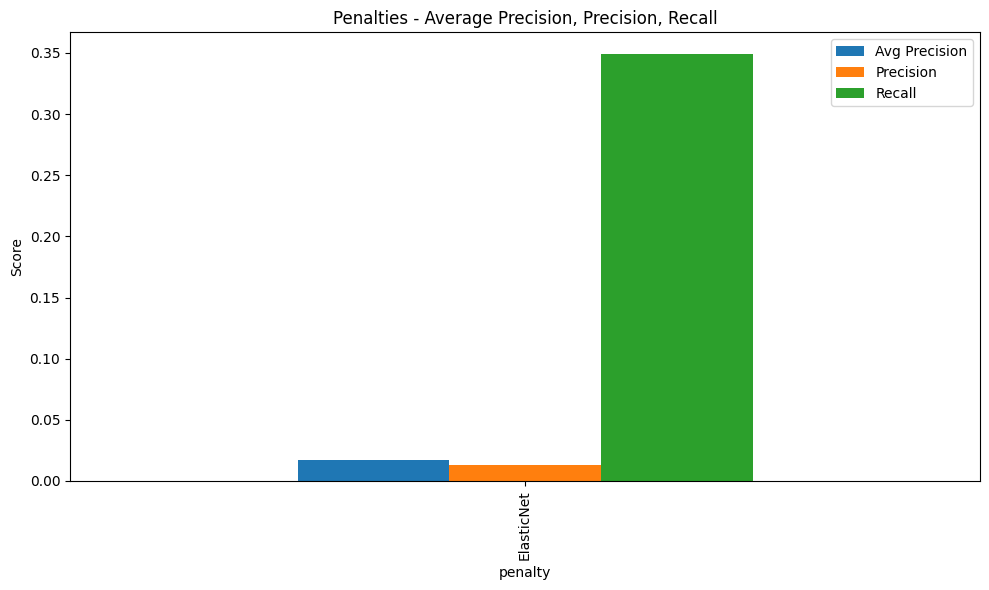

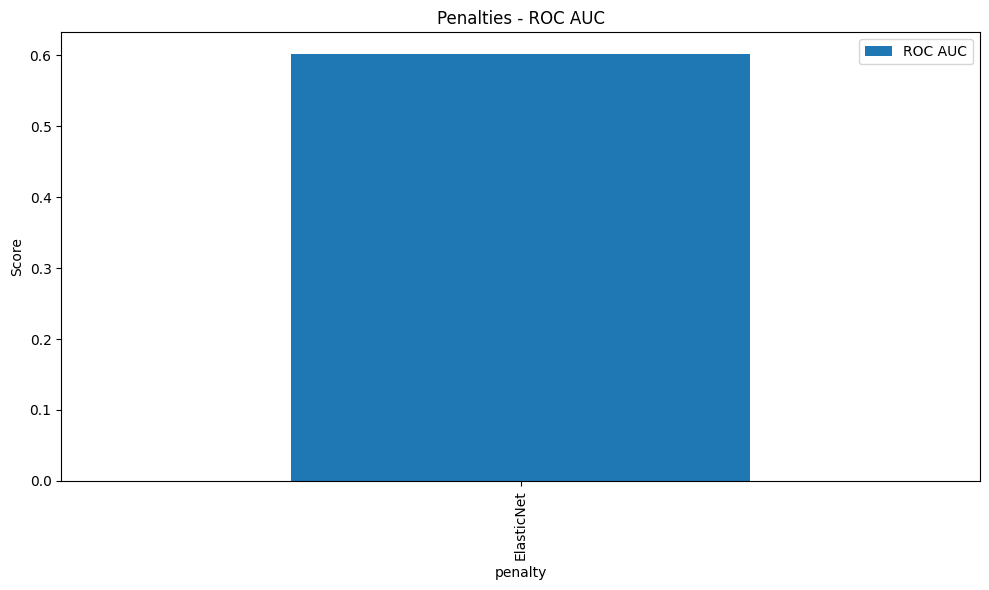

In [ ]:
study_tfbert, results_tfbert = run_xgb_optuna(X_train_tfbert, y_train_tfbert, dataset_name="tfidf_clinicBERT", sampler="ros", cv=cv3)

## 4.4 Gradient Boosting LightGBM + Optuna 

### 4.4.1 TF-IDF + Structure Data

In [72]:
y_train_tfidf.value_counts()

readmit_30days
0    6481
1      63
Name: count, dtype: int64

In [74]:
print("Class distribution:", np.bincount(y_train_tfidf))

Class distribution: [6481   63]


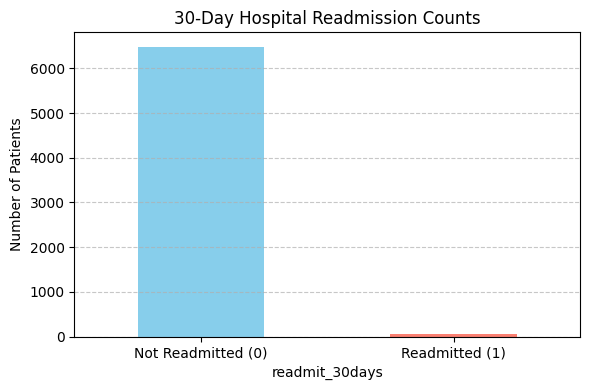

In [102]:
# Count the values
counts = y_train_tfidf.value_counts().sort_index()

# Plot
plt.figure(figsize=(6, 4))
counts.plot(kind='bar', color=['skyblue', 'salmon'])

# Labels and title
plt.xticks(ticks=[0, 1], labels=['Not Readmitted (0)', 'Readmitted (1)'], rotation=0)
plt.ylabel('Number of Patients')
plt.title('30-Day Hospital Readmission Counts')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

Best trial: 47. Best value: 0.037416: 100%|██████████| 100/100 [23:56<00:00, 14.36s/it]


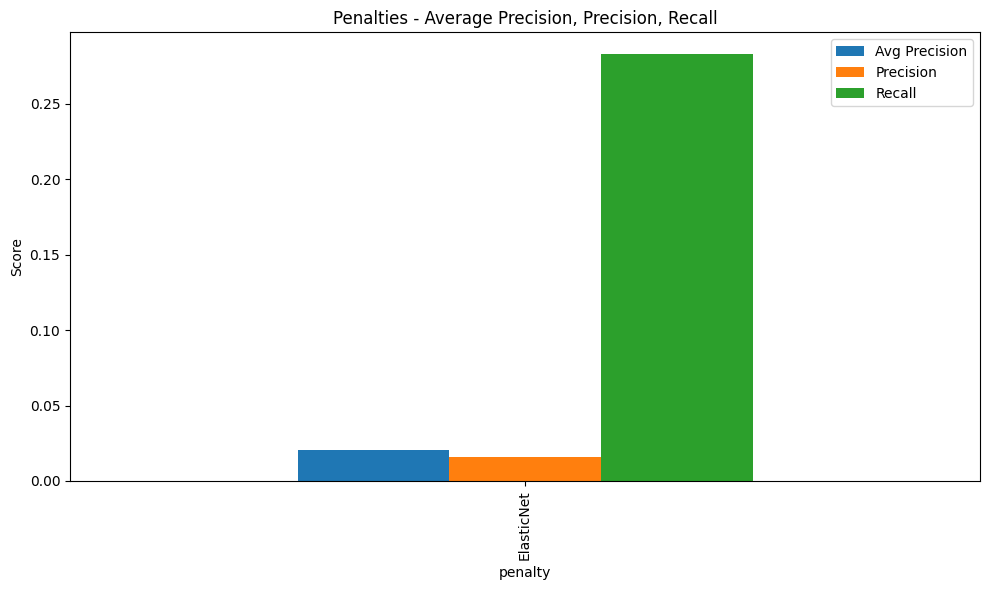

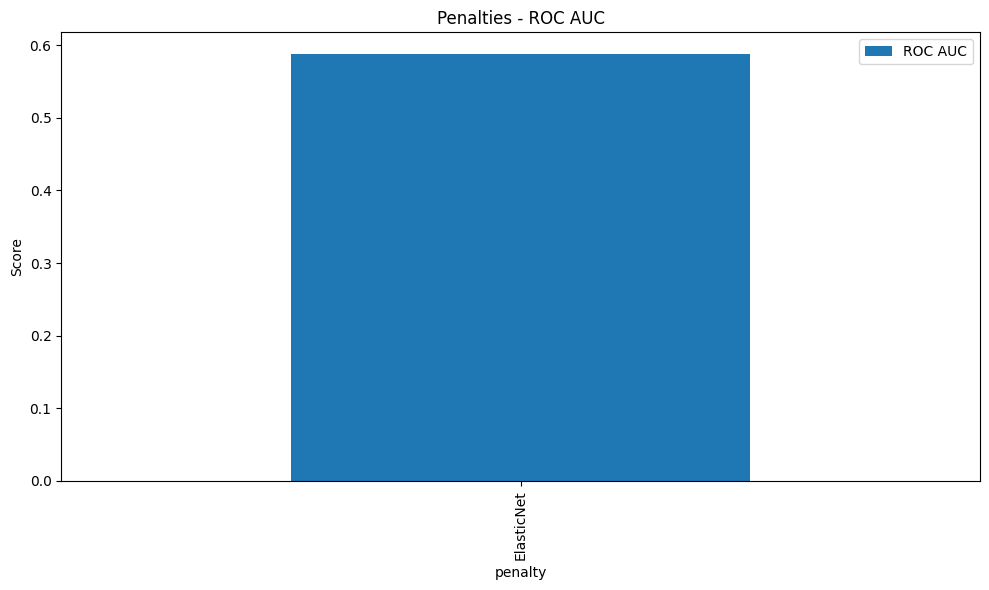

In [ ]:
%matplotlib inline

# run this *before* import
import sys, pathlib
project_root = pathlib.Path.cwd().parent          # notebooks → project root
sys.path.append(str(project_root))

import importlib, utils.lgb_optuna_AP_tuner as t; importlib.reload(t)
from utils.lgb_optuna_AP_tuner import run_lgb_optuna

cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

study_tfidf, results_tfidf = run_lgb_optuna(X_train_tfidf, y_train_tfidf, dataset_name="tfidf", sampler="ros", cv=cv3)

based on the AP scores alone (0.16 for logistic regression vs. 0.034 for LightGBM), logistic regression is outperforming LightGBM on my TF-IDF dataset at this stage—assuming both were evaluated with the same cross-validation setup, metrics, and data splits. This isn't uncommon for high-dimensional sparse text features like TF-IDF, where linear models (like LR with regularization) often provide a strong baseline, while tree-based models like LightGBM may require more tuning (e.g., broader hyperparameter ranges, more trials, or handling sparsity better) to shine. I could re-run the LightGBM Optuna study with fixes (like the lambda ranges) and higher n_trials to see if it closes the gap.

### 4.4.2 ClinicBERT + Structure Data

Best trial: 4. Best value: 0.049673: 100%|██████████| 100/100 [10:48<00:00,  6.48s/it]


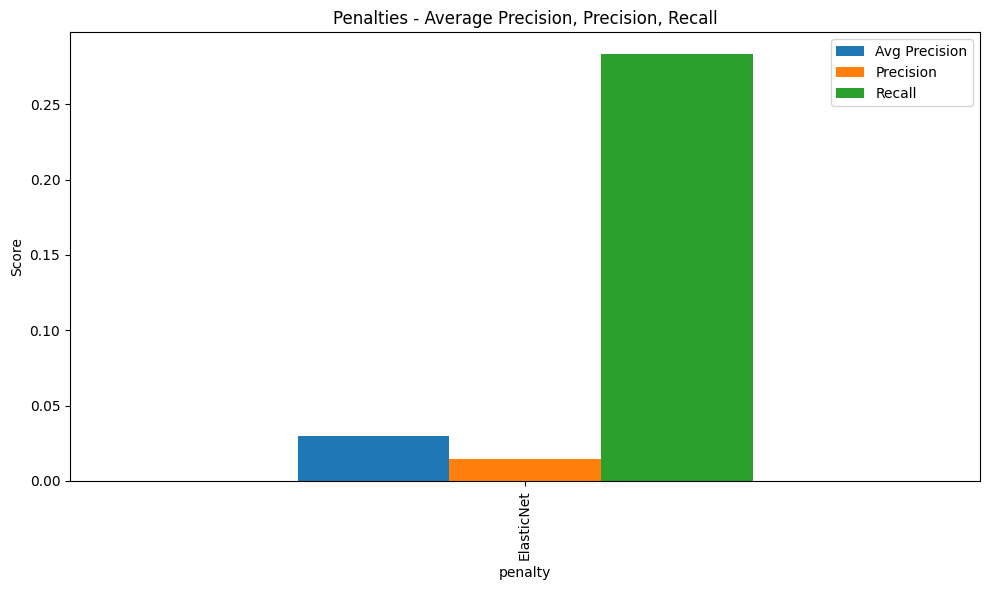

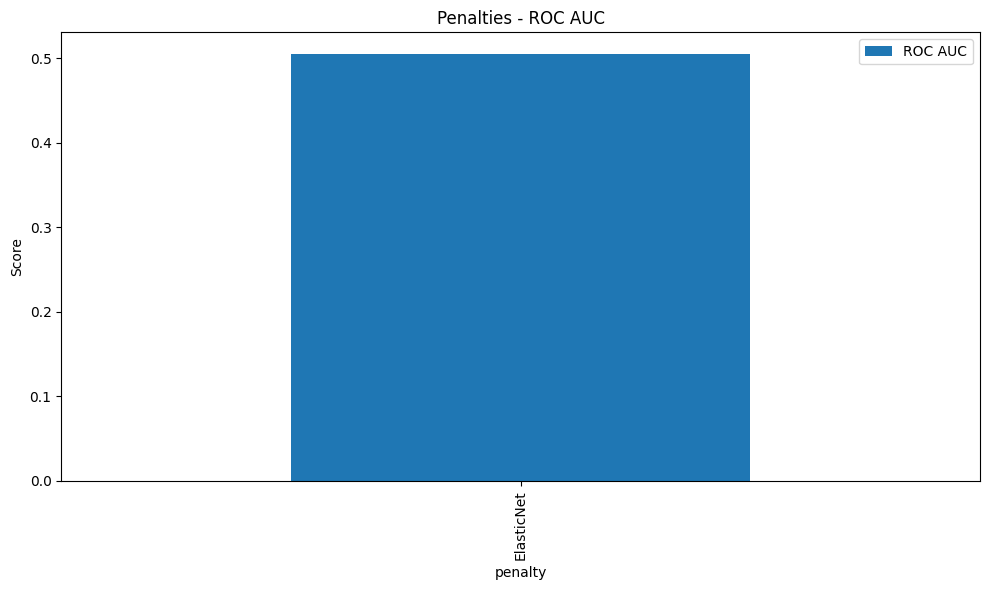

In [76]:
%matplotlib inline

study_cbert, results_cbert = run_lgb_optuna(X_train_cbert, y_train_cbert, dataset_name="clinicBERT", sampler="smote", cv=cv3)

### 4.4.3 TF-IDF + ClinicBERT + Structure Data

Best trial: 0. Best value: 0.0469179: 100%|██████████| 100/100 [36:10<00:00, 21.70s/it]


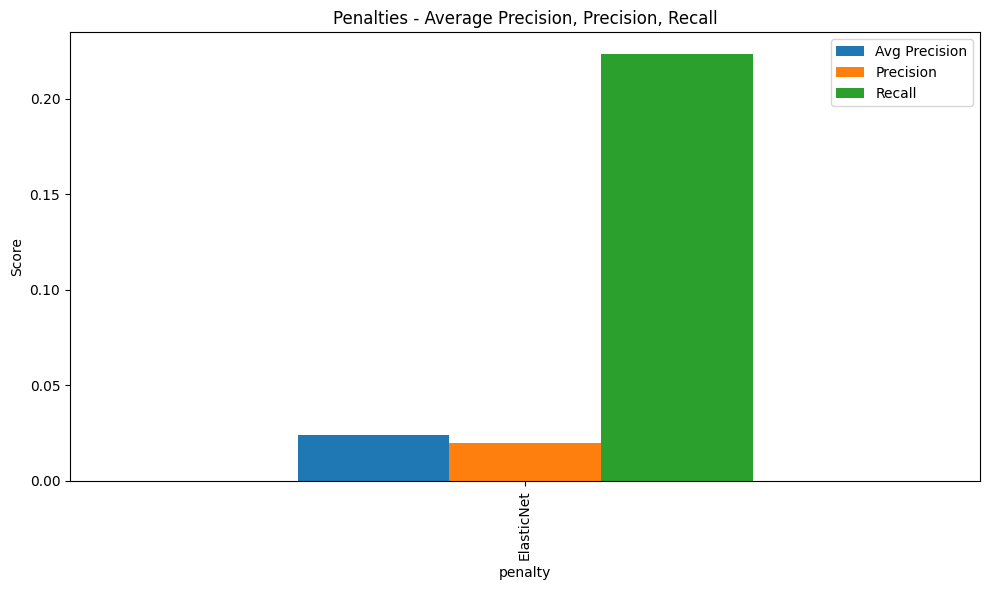

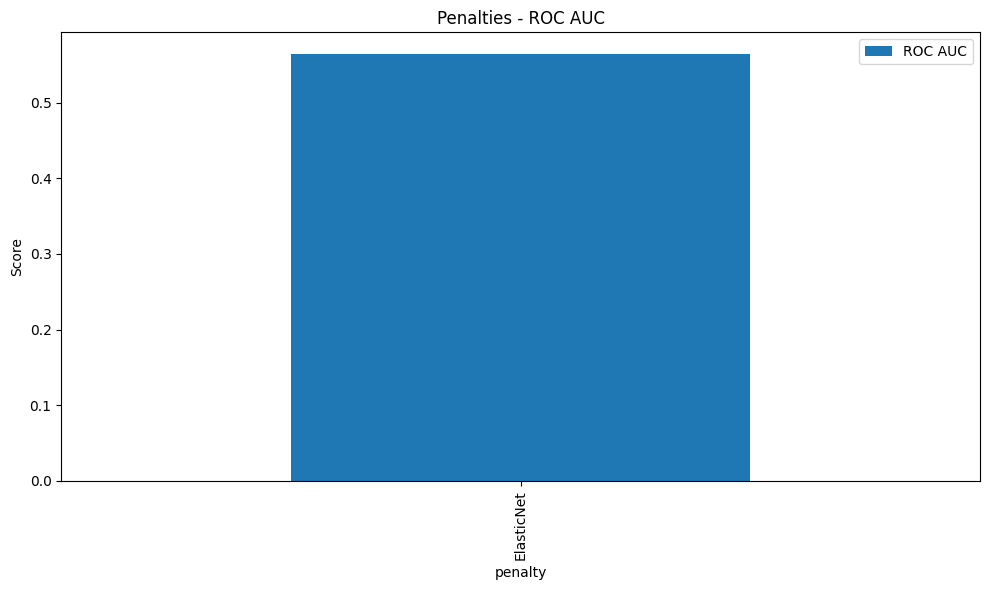

In [77]:
%matplotlib inline

study_tfbert, results_tfbert = run_lgb_optuna(X_train_tfbert, y_train_tfbert, dataset_name="tfidf_clinicBERT", sampler="ros", cv=cv3)

Logistic regression with L1 is the current best. But that may reflect the nature of the data rather than the absolute superiority of the model.

## 4.5 Stacking (RF + LGBM + LR using Stacking Classifier)

***Stacking Structure***
A two-level stack: Level 1 (base models) generates predictions/probabilities, which feed into Level 2 (meta-model) for final blending. This is efficient and avoids overfitting with proper CV. Use 3-5 fold stratified CV (matching my prior setup) for out-of-fold predictions to train the meta-model, ensuring robustness on imbalance.

***Overall Training Flow***

1. Split tfbert into stratified CV folds (e.g., 3-5 splits, shuffle=True, random_state=42).
2. For each fold: Train bases on train sub-fold (with sampling if needed), predict probs on hold-out sub-fold.
3. Collect out-of-fold probs to train the meta-model.
4. Refit bases + meta on full tfbert for the final model.
5. Evaluate with CV metrics (AP, precision, recall, ROC AUC) and plot bars (similar to my prior code).

### 4.5.3 TF-IDF + ClinicBERT + Structure Data

bases (LR + XGB + LGB) + meta (LR)

Level-0 (base learners):

- RF averages many deep, decorrelated trees → low-variance
- LGBM/XGB builds trees sequentially to correct previous errors → low-bias, good at capturing complex interactions

Level-1 (meta learner) -- Logistic Regression (LR): 
- Learns how much to trust each base model for every region of feature space. With the raw features passed through, LR can up-weight one model when certain predictors are present and down-weight it elsewhere.


Because the two level-0 learners make uncorrelated errors, LR can often find decision boundaries in the 2-D “prediction space” (RF_prob, LGBM_prob) that neither original model could draw on its own, nudging borderline cases across the 0.5 threshold and lifting ROC-AUC by a few points.

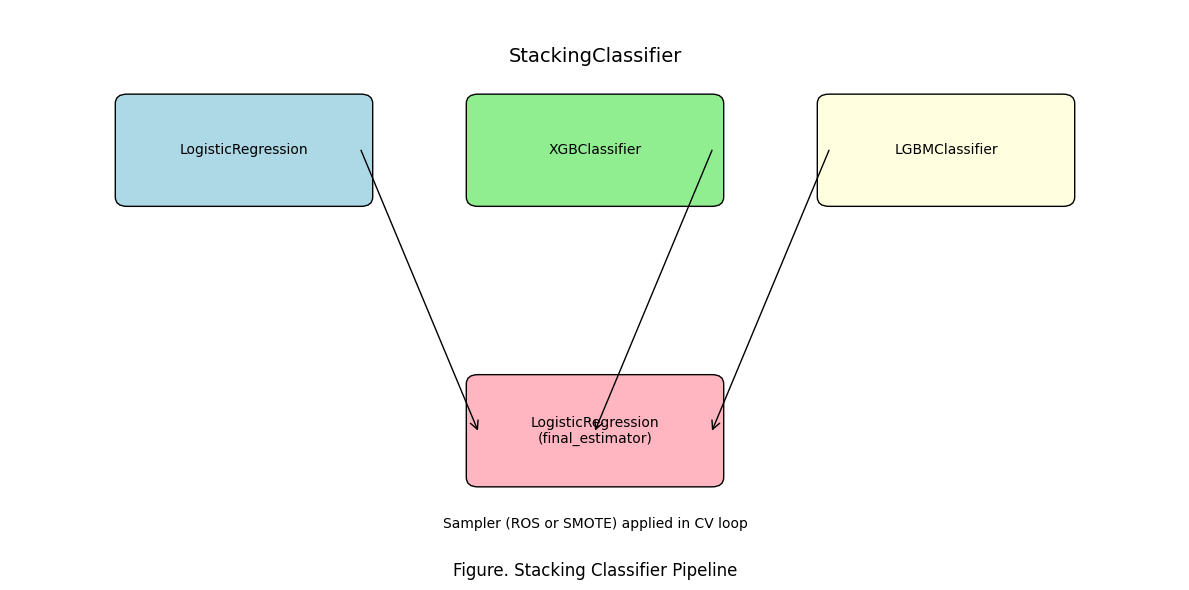

In [124]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, ConnectionPatch

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 6)
ax.axis('off')

# Base models
ax.add_patch(FancyBboxPatch((1, 4), 2, 1, boxstyle="round,pad=0.1", ec="black", fc="lightblue"))
ax.text(2, 4.5, 'LogisticRegression', ha='center', va='center')

ax.add_patch(FancyBboxPatch((4, 4), 2, 1, boxstyle="round,pad=0.1", ec="black", fc="lightgreen"))
ax.text(5, 4.5, 'XGBClassifier', ha='center', va='center')

ax.add_patch(FancyBboxPatch((7, 4), 2, 1, boxstyle="round,pad=0.1", ec="black", fc="lightyellow"))
ax.text(8, 4.5, 'LGBMClassifier', ha='center', va='center')

# Final estimator
ax.add_patch(FancyBboxPatch((4, 1), 2, 1, boxstyle="round,pad=0.1", ec="black", fc="lightpink"))
ax.text(5, 1.5, 'LogisticRegression\n(final_estimator)', ha='center', va='center')

# StackingClassifier label
ax.text(5, 5.5, 'StackingClassifier', ha='center', va='center', fontsize=14)

# Connections from bases to final
con1 = ConnectionPatch(xyA=(3, 4.5), xyB=(4, 1.5), coordsA="data", coordsB="data", arrowstyle="->", mutation_scale=15)
ax.add_artist(con1)

con2 = ConnectionPatch(xyA=(6, 4.5), xyB=(5, 1.5), coordsA="data", coordsB="data", arrowstyle="->", mutation_scale=15)
ax.add_artist(con2)

con3 = ConnectionPatch(xyA=(7, 4.5), xyB=(6, 1.5), coordsA="data", coordsB="data", arrowstyle="->", mutation_scale=15)
ax.add_artist(con3)

# Sampler note (applied in CV loop)
ax.text(5, 0.5, 'Sampler (ROS or SMOTE) applied in CV loop', ha='center', va='center', fontsize=10)

# Title
ax.text(5, 0, 'Figure. Stacking Classifier Pipeline', ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.savefig('stacking_pipeline.png')
plt.show()

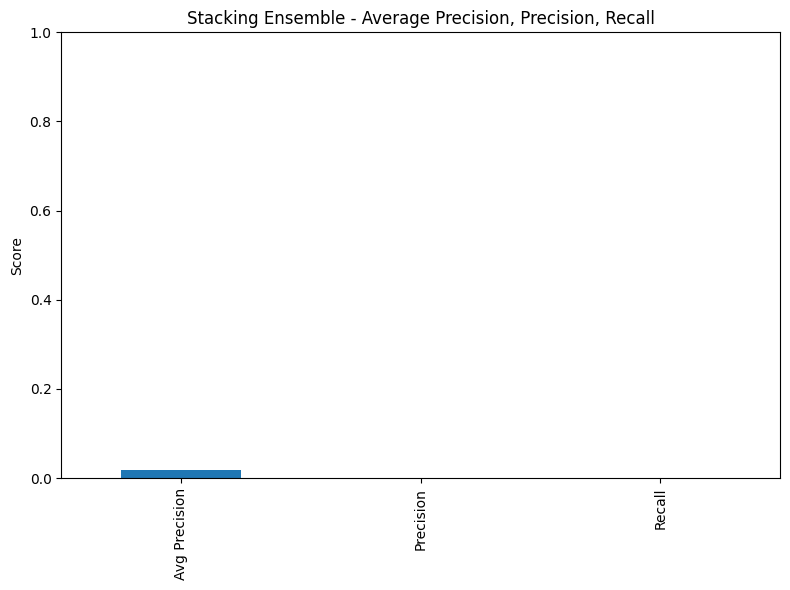

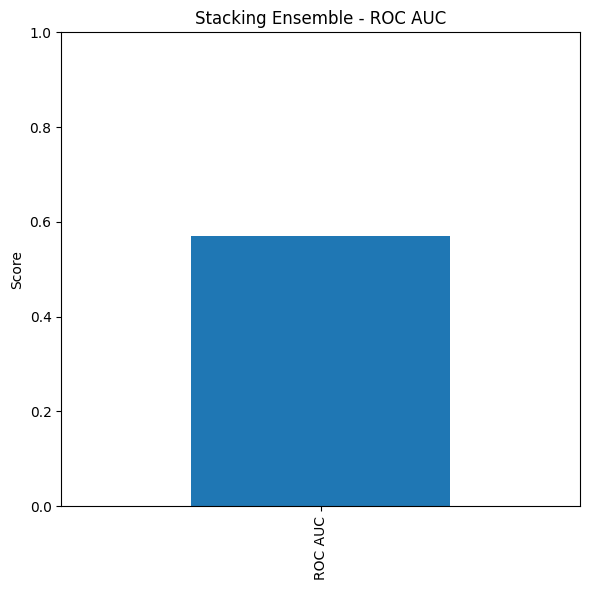

In [ ]:
%matplotlib inline

root_dir = Path.cwd().parent          # notebooks → mimic_readmit_clinbert
saved_dir = root_dir / "saved"

import importlib, utils.stacking_ensemble as t; importlib.reload(t)
from utils.stacking_ensemble import run_stacking_ensemble

# Assuming X_train_tfbert and y_train_tfbert are defined (TF-IDF + ClinicalBERT + structured data)
# Load best params (replace with actual file paths/dates from my Optuna/screening runs)
with open(saved_dir/'clinicBERT/xgb_optuna_best_params_20250718.json') as f:  # From XGB on cbert (best for XGB)
    best_xgb_params = json.load(f)

with open(saved_dir/'clinicBERT/lgb_optuna_best_params_20250718.json') as f:  # From LGB on cbert (best for LGB); or use tfbert if tuned there
    best_lgb_params = json.load(f)

best_lr_params = dict(penalty='l1', C=0.48574509063945326, solver="saga",
                max_iter=3_000, random_state=42,
                class_weight="balanced")

cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

stack_model_tfbert, results_tfbert = run_stacking_ensemble(
    X_train_tfbert, 
    y_train_tfbert, 
    dataset_name="tfidf_clinicBERT", 
    best_lr_params=best_lr_params,
    best_xgb_params=best_xgb_params,
    best_lgb_params=best_lgb_params,
    sampler="ros", 
    cv=cv3
)

In [123]:
# Assuming results_tfbert is already available from the previous cell
print(f"Average Precision (AP) at best parameters: {results_tfbert['ap'][0]:.4f}")

Average Precision (AP) at best parameters: 0.0173


The stacking ensemble's poor performance (AP ~0.017, precision/recall 0, ROC AUC ~0.57) is indeed disappointing and far below my individual model benchmarks (e.g., logreg at ~0.16 AP). This indicates the stack is effectively predicting almost all instances as negative, which is a classic failure mode in highly imbalanced binary classification—leading to trivial recall/precision at the default 0.5 threshold while ROC AUC remains mediocre (as it ranks probabilities without thresholding).

Key Reasons for Underperformance:
1. Severe Class Imbalance Leading to Biased Prediction. 
2. Lack of Diversity in Base Models. 
3. Parameter Mismatch Across Datasets.
4. Overfitting/Underfitting in Stacking Process. 
5. No Guaranteed Gains from Literature.

### 4.5.4 TF-IDF + Structure Data (ROC_AUC Optuna)

In [ ]:



# # ----------------- 0.  Load best-param JSONs ------------------
# param_dir = Path("Saved")

# with (param_dir/"lightgbm_optuna_best_params.json").open() as f:
#     lgb_base = json.load(f)          

# with (param_dir/"random_forest_optuna_best_params.json").open() as f:
#     rf_base = json.load(f)          

# with(param_dir/"logistic_regression_L1_optuna_best_params.json").open() as f:
#     lr_base = json.load(f)          

# # ----------------- 1. CV splitter ------------------
# cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # ----------------- 2. Optuna objective ------------------
# def stack_objective(trial):
#     # --- base learners (inner jobs **single-thread**)
#     rf = RandomForestClassifier(**rf_base, n_jobs=1, random_state=42)
#     lgbm = lgb.LGBMClassifier(**lgb_base, n_jobs=1, random_state=42)

#     # --- meta learner: tune only a few high-impact params
#     C = trial.suggest_float("lr_C", 1e-3, 10.0, log=True)
#     pen = trial.suggest_categorical("lr_penalty", ["l1", "l2"])

#     lr_params = lr_base.copy()
#     lr_params.update(
#         C=C,
#         penalty=pen,
#         solver="saga",
#         n_jobs=1,
#         max_iter=4000,
#         random_state=42,
#     )

#     lr = LogisticRegression(**lr_params)

#     stack = StackingClassifier(
#         estimators=[('rf', rf), ('lgbm', lgbm)],
#         final_estimator=lr,
#         passthrough=True,          # feed original features to meta learner
#         cv=5,                      # internal CV for meta features
#         n_jobs=1                   # keep inner layer single-threaded
#     )

#     # outer CV parallelised – only one level of parallelism
#     auc = cross_val_score(stack, X_train, y_train,
#                           cv=cv_outer,
#                           scoring="roc_auc",
#                           n_jobs=-1).mean()
#     return auc

# # ----------------- 3.  Run study -----------------------
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# sampler = optuna.samplers.TPESampler(seed=42)
# study   = optuna.create_study(direction="maximize",
#                               sampler=sampler,
#                               study_name="Stack_RF_LGBM_LR")

# with tqdm(total=30, desc="Optimising stack") as pbar:
#     study.optimize(stack_objective,
#                    n_trials=30,
#                    callbacks=[lambda s, t: pbar.update()])

# print(f"Best AUC : {study.best_value:.4f}")

# # ----------------- 4.  Train final model --------------------
# best = study.best_params
# rf_final  = RandomForestClassifier(**rf_base,  n_jobs=1, random_state=42)
# lgb_final = lgb.LGBMClassifier(**lgb_base,     n_jobs=1, random_state=42)

# # --- build a clean parameter set for the meta-learner
# lr_params = lr_base.copy()            # start from the Optuna-best L1 baseline
# lr_params.update(
#     C=best["lr_C"],                  # overwrite the tuned values …
#     penalty=best["lr_penalty"],
#     solver="saga",                   # keep the solver compatible with L1/L2
#     n_jobs=1,
#     max_iter=4000,
#     random_state=42,
# )

# lr_final = LogisticRegression(**lr_params)

# final_stack = StackingClassifier(
#     estimators=[("rf", rf_final), ("lgbm", lgb_final)],
#     final_estimator=lr_final,
#     passthrough=True,
#     cv=5,
#     n_jobs=-1                # only here we parallelise prediction
# ).fit(X_train, y_train)

# # ----------------- 5.  Persist artefacts --------------------
# param_dir.mkdir(exist_ok=True)
# joblib.dump(study,       param_dir/"stack_study.pkl")
# joblib.dump(final_stack, param_dir/"stack_model.pkl")
# with (param_dir/"stack_best_params.json").open("w") as f:
#     json.dump(best, f, indent=2)

# pd.DataFrame({
#     "trial": [t.number for t in study.trials],
#     "auc"  : [t.value  for t in study.trials]
# }).to_csv(param_dir/"stack_trial_scores.csv", index=False)

# # Optional plot
# plt.figure(figsize=(8,4))
# plt.plot([t.value for t in study.trials], marker="o")
# plt.axhline(study.best_value, ls="--")
# plt.title("Stacking ROC-AUC per Trial"); plt.xlabel("Trial"); plt.ylabel("ROC-AUC")
# plt.tight_layout(); plt.savefig(param_dir/"stack_trials.png", dpi=300); plt.show()

### 4.5.5 ClinicBERT + Structure Data (ROC_AUC Optuna)

In [78]:
# # ----------------- 0.  Load best-param JSONs ------------------
# param_dir = Path("Saved")

# with (param_dir/"lightgbm_optuna_best_params.json").open() as f:
#     lgb_base = json.load(f)          

# with (param_dir/"random_forest_optuna_best_params.json").open() as f:
#     rf_base = json.load(f)          

# with(param_dir/"logistic_regression_L1_optuna_best_params.json").open() as f:
#     lr_base = json.load(f)          

# # ----------------- 1. CV splitter ------------------
# cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # ----------------- 2. Optuna objective ------------------
# def stack_objective(trial):
#     # --- base learners (inner jobs **single-thread**)
#     rf = RandomForestClassifier(**rf_base, n_jobs=1, random_state=42)
#     lgbm = lgb.LGBMClassifier(**lgb_base, n_jobs=1, random_state=42)

#     # --- meta learner: tune only a few high-impact params
#     C = trial.suggest_float("lr_C", 1e-3, 10.0, log=True)
#     pen = trial.suggest_categorical("lr_penalty", ["l1", "l2"])

#     lr_params = lr_base.copy()
#     lr_params.update(
#         C=C,
#         penalty=pen,
#         solver="saga",
#         n_jobs=1,
#         max_iter=4000,
#         random_state=42,
#     )

#     lr = LogisticRegression(**lr_params)

#     stack = StackingClassifier(
#         estimators=[('rf', rf), ('lgbm', lgbm)],
#         final_estimator=lr,
#         passthrough=True,          # feed original features to meta learner
#         cv=5,                      # internal CV for meta features
#         n_jobs=1                   # keep inner layer single-threaded
#     )

#     # outer CV parallelised – only one level of parallelism
#     auc = cross_val_score(stack, X_train, y_train,
#                           cv=cv_outer,
#                           scoring="roc_auc",
#                           n_jobs=-1).mean()
#     return auc

# # ----------------- 3.  Run study -----------------------
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# sampler = optuna.samplers.TPESampler(seed=42)
# study   = optuna.create_study(direction="maximize",
#                               sampler=sampler,
#                               study_name="Stack_RF_LGBM_LR")

# with tqdm(total=30, desc="Optimising stack") as pbar:
#     study.optimize(stack_objective,
#                    n_trials=30,
#                    callbacks=[lambda s, t: pbar.update()])

# print(f"Best AUC : {study.best_value:.4f}")

# # ----------------- 4.  Train final model --------------------
# best = study.best_params
# rf_final  = RandomForestClassifier(**rf_base,  n_jobs=1, random_state=42)
# lgb_final = lgb.LGBMClassifier(**lgb_base,     n_jobs=1, random_state=42)

# # --- build a clean parameter set for the meta-learner
# lr_params = lr_base.copy()            # start from the Optuna-best L1 baseline
# lr_params.update(
#     C=best["lr_C"],                  # overwrite the tuned values …
#     penalty=best["lr_penalty"],
#     solver="saga",                   # keep the solver compatible with L1/L2
#     n_jobs=1,
#     max_iter=4000,
#     random_state=42,
# )

# lr_final = LogisticRegression(**lr_params)

# final_stack = StackingClassifier(
#     estimators=[("rf", rf_final), ("lgbm", lgb_final)],
#     final_estimator=lr_final,
#     passthrough=True,
#     cv=5,
#     n_jobs=-1                # only here we parallelise prediction
# ).fit(X_train, y_train)

# # ----------------- 5.  Persist artefacts --------------------
# param_dir.mkdir(exist_ok=True)
# joblib.dump(study,       param_dir/"stack_study.pkl")
# joblib.dump(final_stack, param_dir/"stack_model.pkl")
# with (param_dir/"stack_best_params.json").open("w") as f:
#     json.dump(best, f, indent=2)

# pd.DataFrame({
#     "trial": [t.number for t in study.trials],
#     "auc"  : [t.value  for t in study.trials]
# }).to_csv(param_dir/"stack_trial_scores.csv", index=False)

# # Optional plot
# plt.figure(figsize=(8,4))
# plt.plot([t.value for t in study.trials], marker="o")
# plt.axhline(study.best_value, ls="--")
# plt.title("Stacking ROC-AUC per Trial"); plt.xlabel("Trial"); plt.ylabel("ROC-AUC")
# plt.tight_layout(); plt.savefig(param_dir/"stack_trials.png", dpi=300); plt.show()

No complementary signal: RF and LGBM aren’t adding information that LR-L1 doesn’t already capture. The meta-learner is just blending noise with a strong predictor → dilution of AUC.

| Model                        | Best ROC AUC | Notes                                   |
| ---------------------------- | ------------ | --------------------------------------- |
| **Logistic Regression (L1)** | **0.675**    | Highest score; simpler model            |
| Stacking ensemble (RF + LGBM + LR)| 0.6568  | Second-best                             |
| LightGBM + Optuna            | 0.6423       | fast and scalable                       |
| XGBoost + Optuna             | 0.6393       | Slightly behind LightGBM                |
| Random Forest + Optuna       | 0.6117       | Lowest; stable but less performant here |



# 5. Precision recall thresholding curve for the best model

In my screening results for the three datasets (tfidf: TF-IDF + structured features; cbert: ClinicalBERT embeddings + structured; tfbert: TF-IDF + ClinicalBERT + structured) across logreg, XGB, LGB and stacking ensemble(bases:logreg + XGB + LGB, meta: logreg) optimized for average precision (AP), logreg on tfbert with L1 regularization outperformed finally with the highest AP value--0.16. I will make a precision recall curves for the best model, and think about what the best threshold is. 

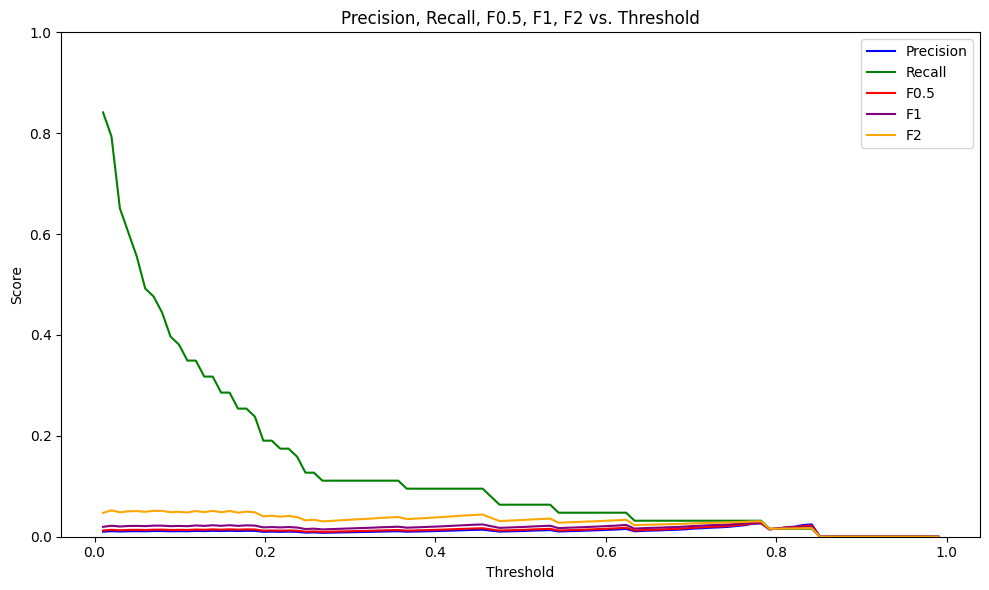

In [ ]:
%matplotlib inline

best_lr_params = dict(penalty='l1', C=0.48574509063945326, solver="saga",
                max_iter=3_000, random_state=42,
                class_weight="balanced")

# Set up CV (matching my prior setup)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipeline with SMOTE and LR (ensure L1 if not in params; adjust if needed)
pipe = ImbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(**best_lr_params)),
])

# Get cross-validated probabilities (on full train for evaluation)
y_prob = cross_val_predict(
    pipe, X_train_tfbert, y_train_tfbert,
    cv=cv, method="predict_proba", n_jobs=1
)[:, 1]  # Positive class probabilities

# Generate thresholds (fine-grained for smooth curves)
thresholds = np.linspace(0.01, 0.99, 100)  # Avoid extremes to prevent division by zero

# Compute metrics for each threshold
precisions = []
recalls = []
f05_scores = []
f1_scores = []
f2_scores = []

for thresh in thresholds:
    y_pred = (y_prob >= thresh).astype(int)
    prec = precision_score(y_train_tfbert, y_pred, zero_division=0)
    rec = recall_score(y_train_tfbert, y_pred, zero_division=0)
    f05 = fbeta_score(y_train_tfbert, y_pred, beta=0.5, zero_division=0)
    f1 = fbeta_score(y_train_tfbert, y_pred, beta=1, zero_division=0)
    f2 = fbeta_score(y_train_tfbert, y_pred, beta=2, zero_division=0)
    
    precisions.append(prec)
    recalls.append(rec)
    f05_scores.append(f05)
    f1_scores.append(f1)
    f2_scores.append(f2)

# Plot the curves
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(thresholds, precisions, label='Precision', color='blue')
ax.plot(thresholds, recalls, label='Recall', color='green')
ax.plot(thresholds, f05_scores, label='F0.5', color='red')
ax.plot(thresholds, f1_scores, label='F1', color='purple')
ax.plot(thresholds, f2_scores, label='F2', color='orange')

ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, F0.5, F1, F2 vs. Threshold')
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.show()

**Observations**:
   1. Precision Curve (Blue): Starts around ~0.05 at low thresholds and remains very low (<0.05) across most thresholds, only rising slightly near 1.0 (but that's meaningless as recall drops to 0). As noted, this implies that even at optimal points, if I predict 100 positives, fewer than 5 are true positives—over 95% false positives (FPs). This is a hallmark of severe class imbalance: the model struggles to distinguish rare positives from abundant negatives, flooding predictions with FPs.
   2. Recall Curve (Green): Begins high (~1.0 at threshold 0.0, catching all positives) but plummets sharply as threshold increases (e.g., drops below 0.2 by ~0.2 threshold). This means the model can identify positives only if very lenient (low threshold), but even small increases in conservatism miss most positives. The dramatic drop suggests the model's probability scores for positives are not well-separated from negatives—many true positives get low probs.
   3. F-Scores (Red for F0.5, Purple for F1, Orange for F2): All hug the bottom (<0.1 across thresholds), staying relatively stable but near-zero after the initial drop. F0.5 (precision-weighted) is lowest, reflecting poor precision; F2 (recall-weighted) is slightly higher at low thresholds but still dismal. Stability here is deceptive—it's because both precision and recall are so poor that their balances don't fluctuate much. No threshold yields a good F-score (>0.2-0.3), indicating no "sweet spot" for practical use.

**Overall Interpretation**: 

   This result screams "highly imbalanced dataset with weak signal." The model has some discriminative power (as my earlier AP ~0.16 suggests it ranks positives better than random), but at any usable threshold, it's overwhelmed by FPs. Recall crashing while precision stays flat/low points to poor calibration—probabilities aren't confident for positives. This could mean the features (TF-IDF + BERT + structured) *capture noise more than predictive patterns*, or *imbalance (~1% positives?) dominates*. It's not useless (better than random guessing), but suboptimal for deployment without adjustments like cost-sensitive thresholds or more data/augmentation.

# 6. Feature importance via SHAP Analysis

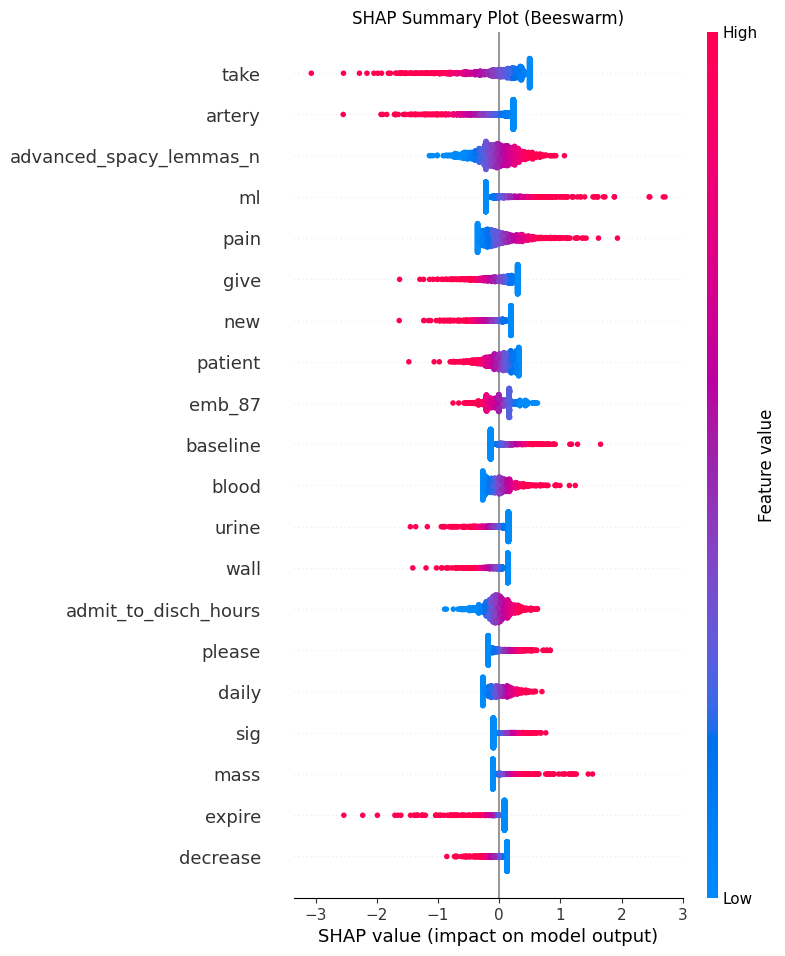

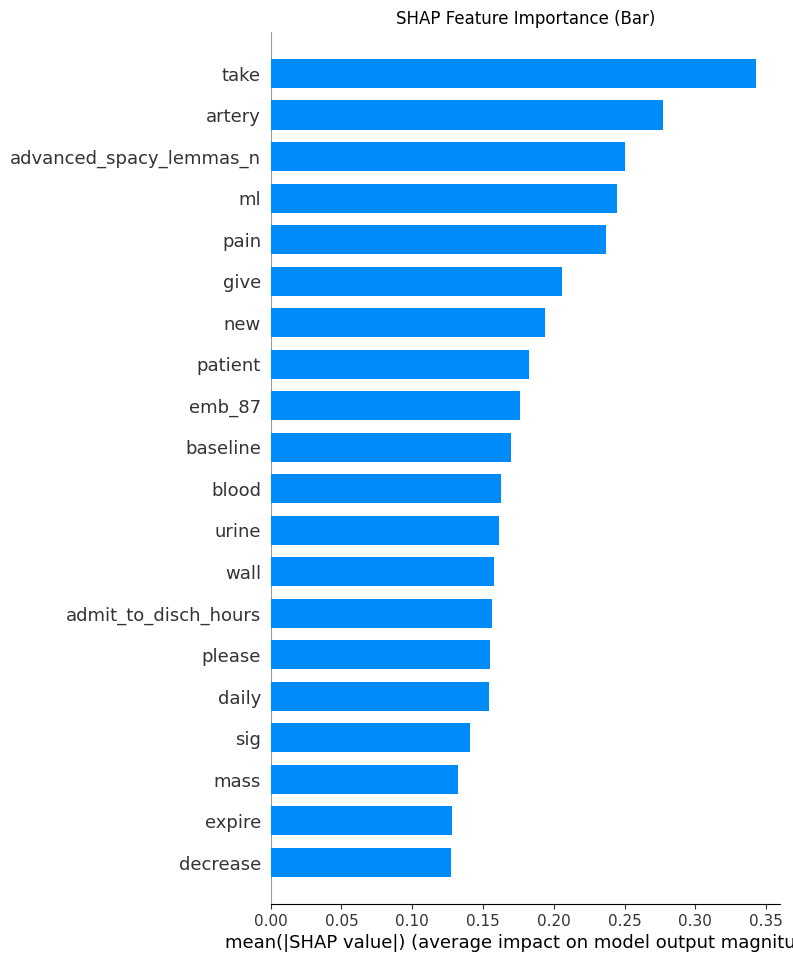

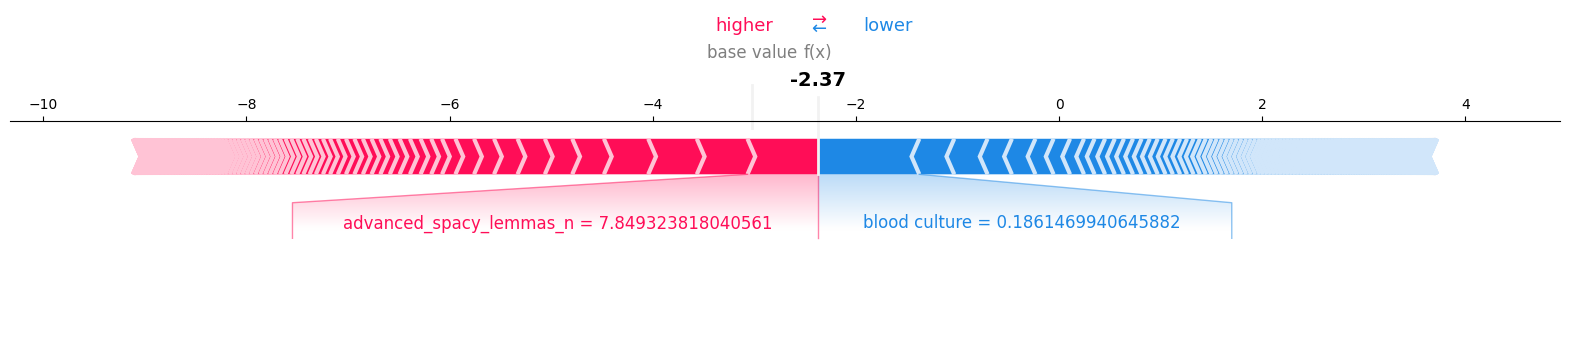

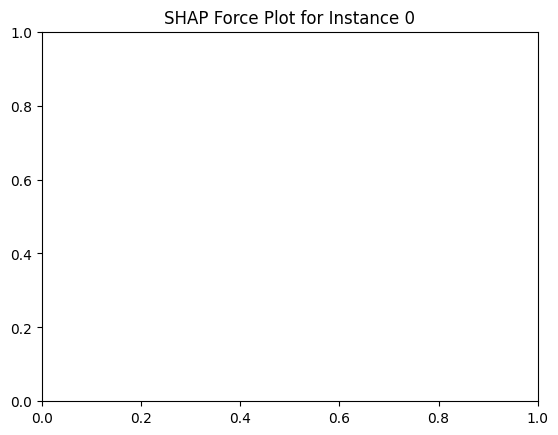

In [89]:
%matplotlib inline

# Split a small test set for explanation (or use full train; adjust as needed)
X_train, X_explain, y_train, y_explain = train_test_split(
    X_train_tfbert, y_train_tfbert, test_size=0.2, stratify=y_train_tfbert, random_state=42
)

# Pipeline for fitting (SMOTE + LR)
pipe = ImbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(**best_lr_params)),
])

# Fit on train
pipe.fit(X_train, y_train)

# Extract the fitted LR model (SHAP explains the classifier, not the sampler)
lr_model = pipe.named_steps['clf']

# Prepare background data for SHAP (summary of training data; use a sample for efficiency)
# If data is sparse, convert to dense if needed; adjust sample size based on compute
background = shap.kmeans(X_train, 50).data  # Condensed summary (k=50 clusters)

# Use LinearExplainer for LogisticRegression (efficient for linear models)
explainer = shap.LinearExplainer(lr_model, background, feature_perturbation="interventional")

# Compute SHAP values on explain set (or a subset for speed)
shap_values = explainer.shap_values(X_explain)

# If multi-class or binary logistic, shap_values will be for positive class

# Visualizations

# 1. Summary plot (beeswarm: global feature importance)
shap.summary_plot(shap_values, X_explain, show=False)
plt.title("SHAP Summary Plot (Beeswarm)")
plt.show()

# 2. Bar plot (mean absolute SHAP values for feature importance)
shap.summary_plot(shap_values, X_explain, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Bar)")
plt.show()

# 3. Force plot for a single prediction (e.g., first instance)
# Adjust index as needed
instance_idx = 0
shap.force_plot(explainer.expected_value, shap_values[instance_idx], X_explain.iloc[instance_idx], matplotlib=True)
plt.title(f"SHAP Force Plot for Instance {instance_idx}")
plt.show()

# Optional: Dependence plot for a specific feature (replace 'feature_name' with actual)
# shap.dependence_plot('feature_name', shap_values, X_explain)

# Save SHAP values if needed
shap_df = pd.DataFrame(shap_values, columns=X_explain.columns)
shap_df.to_csv(saved_dir / f"shap_values_tfbert_logreg_{ts}.csv", index=False)

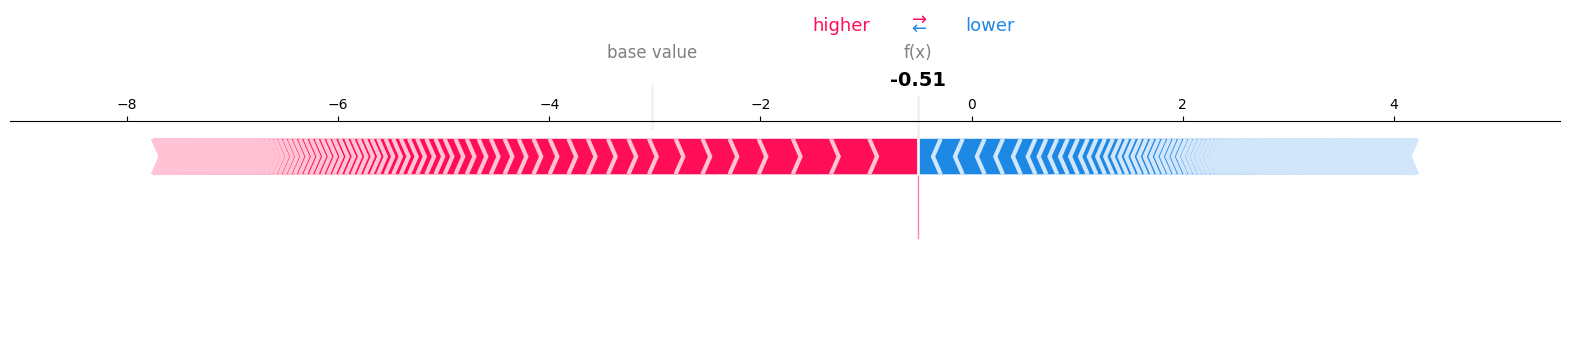

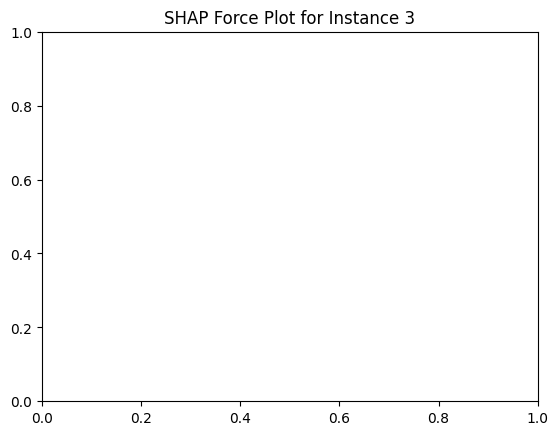

In [92]:
instance_idx = 3
shap.force_plot(explainer.expected_value, shap_values[instance_idx], X_explain.iloc[instance_idx], matplotlib=True)
plt.title(f"SHAP Force Plot for Instance {instance_idx}")
plt.show()


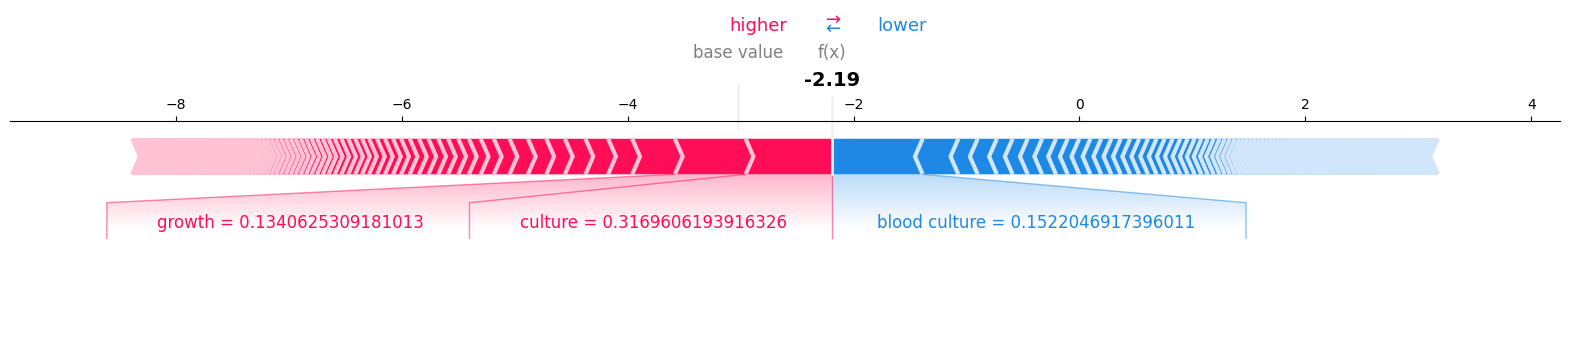

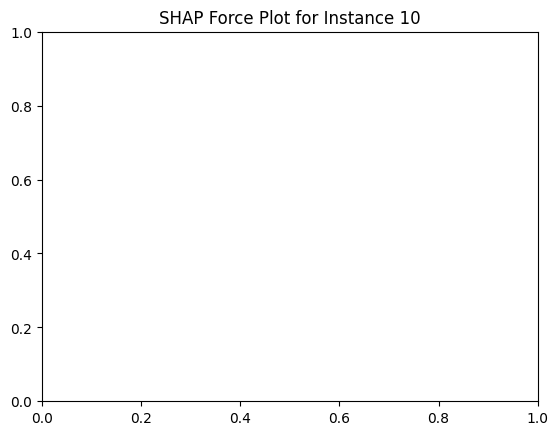

In [93]:
instance_idx = 10
shap.force_plot(explainer.expected_value, shap_values[instance_idx], X_explain.iloc[instance_idx], matplotlib=True)
plt.title(f"SHAP Force Plot for Instance {instance_idx}")
plt.show()


**Observations**:
   1.  Reasonable Features: "Pain", "artery", "blood" make sense (predicting adverse outcomes like pain events or vascular issues). "Advanced_spacy_lemmas_n" (counts of lemmatized tokens from spaCy NLP) and "admit_to_disch_hours" (structured: hospital stay duration) are intuitive—longer stays or more lemmas could correlate with positives. "Emb_87" might be a ClinicalBERT embedding dimension capturing semantic patterns.
   2.  Unreasonable Features: "Take", "ml", "give", "new", "patient", "baseline", "please" seem generic/stopword-like (e.g., from clinical notes: "take medication", "give 5 ml", "new patient", "please note"). In TF-IDF, common terms get low weights, but if frequent in positives (e.g., instructions in positive cases), they could rank high. This often happens in imbalanced text models: neutral words appear "important" due to correlation (not causation) or data artifacts (e.g., boilerplate text in positive records). "Baseline" might refer to medical baselines but could be noisy if ambiguous. SHAP highlights associations, not semantics—so these might be proxies for patterns (e.g., "take" correlates with medication mentions in positives) but indicate overfitting to noise rather than meaningful signals.
   3.  Higher Values of "Take" and "Artery" Having Negative Impact:
      - What "Value" Means: In SHAP beeswarm, "feature value" (color) is the raw input value for that feature in an instance. For TF-IDF features like "take" or "artery", this is the TF-IDF score (0 to 1+; higher = more frequent/important in the document relative to corpus). For structured like "admit_to_disch_hours", it's the numeric value (e.g., hours). For BERT embeddings ("emb_87"), it's the vector component (-1 to 1 typically). Red dots = high values push SHAP in their direction; blue = low.
      - Why Negative Impact for Higher Values?: For "take" and "artery", red dots (high values) cluster on the left (negative SHAP), meaning higher occurrences/TF-IDF of these terms decrease the predicted probability of positive class. This counterintuitive result could mean:
          - Inverse Correlation: In my data, frequent "take" (e.g., "take meds") or "artery" mentions appear more in negatives (routine notes) than positives (rare events). Or, positives have sparse mentions, so high values signal "normal" cases.
          - Model Learning Spurious Patterns: LR with L1 might penalize these as noise, assigning negative coefficients. In imbalance, the model prioritizes avoiding FPs, so features common in negatives get negative weights.
          - Collinearity/Interactions: These interact with others (e.g., high "artery" + low "pain" = negative). SHAP shows marginal contributions, so a feature positive in isolation could be negative overall.
          - Data Artifacts: If "artery" is from misparsed text or correlated with negatives (e.g., artery scans in stable patients), it pulls predictions down.
  
        - This doesn't invalidate the model but highlights potential issues: noisy features or insufficient positives to learn true associations.

**Summary**:
Overall, Is the Modeling Failing?

Not completely failing, but it's underperforming and likely not ready for real-world use without fixes. Here's a balanced view:

- Strengths/Signs of Success:
    - AP ~0.16 is better than random (0.01-0.05 for 1% imbalance), showing some signal capture (e.g., reasonable features like "pain", "blood").
    - SHAP reveals interpretable patterns (e.g., medical terms dominating), useful for domain insights/refinement.
    - Threshold chart shows tunable recall at low thresholds, potentially viable if FPs are tolerable (e.g., screening tool).
- Weaknesses/Signs of Failure:
    - Dismal precision/F-scores indicate FP overload—model isn't precise enough for tasks needing low errors (e.g., clinical alerts).
    - Unreasonable SHAP features suggest overfitting to noise/correlations, common in high-dim text data with imbalance.
    - No threshold balances prec/recall well, and negative impacts on intuitive features like "artery" hint at data/model mismatches.
- Why This Happens/Recommendations:
    - Severe Imbalance: With few positives, models learn "predict negative always" as safe. Fix: More aggressive sampling (e.g., SMOTE ratio=1.0), focal loss, or ensemble with calibrated boosters.
    - Feature Engineering: Prune generic tokens ("take", "please") via stopword removal or feature selection. For BERT, fine-tune on  my task.
    - Model Choices: LR is simple but limited; try calibrated XGB/LGB on tfbert or DL (e.g., BERT classifier) for better separation.
    - Evaluation: Test on hold-out data; compute AUPRC (my AP is this) vs. AUROC (inflated in imbalance). Aim for prec>0.1 at rec=0.5.
    - Not Total Failure: It ranks positives somewhat (AP>baseline), so iterate—add positives, clean features, or hybrid models.

If AP stalls, collect more data or use transfer learning. Share positive count/dataset size for tailored advice!

# 7. Save and Export a Conda Environment (.yml)

## 7.1 Save

In [91]:
root_dir = Path.cwd().parent          # notebooks → mimic_readmit_clinbert
saved_dir = root_dir / "saved"

# Save the model with a timestamp to avoid overwriting
timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
filename = f"lr_model_best_params_{timestamp}.joblib"
joblib.dump(lr_model, saved_dir / filename)

['c:\\Users\\Sheng Miao\\mimic_readmit_clinbert\\saved\\lr_model_best_params_20250721_133922.joblib']

## 7.2 Export a Conda Environment (.yml)

In [101]:
import datetime
from pathlib import Path
import subprocess
import os

# Define paths and parameters
env_name = "readm"
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
saved_dir = Path(r"c:\Users\Sheng Miao\mimic_readmit_clinbert\saved")
yml_file = saved_dir / f"env_{env_name}_{timestamp}.yml"

# Ensure directory exists
saved_dir.mkdir(parents=True, exist_ok=True)

try:
    # Attempt to export the current environment
    result = subprocess.run(
        ['conda', 'env', 'export'], 
        capture_output=True, 
        text=True, 
        check=False,
        shell=True  # Use shell to handle Windows command context better
    )
    
    # Check the result
    if result.returncode == 0:
        with open(yml_file, 'w', encoding='utf-8') as f:  # Explicit encoding
            f.write(result.stdout)
        print(f"Environment exported to: {yml_file}")
        print(f"File size: {os.path.getsize(yml_file)} bytes")
        with open(yml_file, 'r', encoding='utf-8') as f:
            print(f"First 200 characters of content: {f.read()[:200]}")
    else:
        print(f"Conda command failed with return code {result.returncode}")
        print(f"Stdout: {result.stdout}")
        print(f"Stderr: {result.stderr}")

except PermissionError as e:
    print(f"Permission denied: {e}. This should not occur with Full Control.")
except FileNotFoundError:
    print("Conda executable not found. Check if Conda is in your PATH.")
except Exception as e:
    print(f"Unexpected error: {e}")

# Additional diagnostic: Check Conda info
print("\nConda info diagnostic:")
!conda info

Environment exported to: c:\Users\Sheng Miao\mimic_readmit_clinbert\saved\env_readm_20250721_145629.yml
File size: 5789 bytes
First 200 characters of content: name: C:\Users\Sheng Miao\mimic_readmit_clinbert\.venv
channels:
  - conda-forge
  - defaults
  - https://repo.anaconda.com/pkgs/main
  - https://repo.anaconda.com/pkgs/r
  - https://repo.anaconda.com

Conda info diagnostic:

     active environment : C:\Users\Sheng Miao\mimic_readmit_clinbert\.venv
    active env location : C:\Users\Sheng Miao\mimic_readmit_clinbert\.venv
            shell level : 1
       user config file : C:\Users\Sheng Miao\.condarc
 populated config files : C:\Users\Sheng Miao\anaconda3\.condarc
                          C:\Users\Sheng Miao\.condarc
          conda version : 24.11.3
    conda-build version : 24.9.0
         python version : 3.12.3.final.0
                 solver : libmamba (default)
       virtual packages : __archspec=1=skylake
                          __conda=24.11.3=0
                  